In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from utils.dataset import load_train_set, load_test_set, load_labels_map, create_train_validation_split
from torch.utils.data import DataLoader
from utils.early_stopping import EarlyStopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(81124)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

cuda


In [3]:
cf_train_set = load_train_set('cifar-10-batches-py')
cf_test_set = load_test_set('cifar-10-batches-py')
labels_map = load_labels_map('cifar-10-batches-py')

Calculate the Mean and Std of the train dataset for each channel

In [4]:
mean = np.mean(cf_train_set.imgs / 255, axis=(0, 1, 2))
std = np.std(cf_train_set.imgs / 255, axis=(0, 1, 2))

print("Mean: ", mean)
print("Std: ", std)

Mean:  [0.49139968 0.48215841 0.44653091]
Std:  [0.24703223 0.24348513 0.26158784]


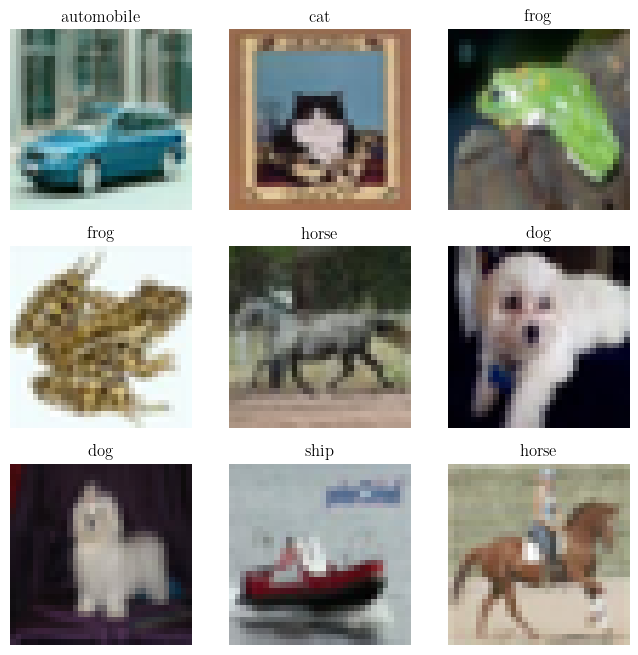

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(len(cf_train_set.imgs), size=(1,)).item())
    label = cf_train_set.labels[sample_idx]
    img = cf_train_set.imgs[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
from utils.dataset import CF10AugmentedDataset, CF10Dataset

test_ds = CF10Dataset(cf_test_set.imgs, cf_test_set.labels)

train_set, val_set = create_train_validation_split(cf_train_set, 0.1)
train_ds = CF10Dataset(train_set.imgs, train_set.labels)
# train_aug_3_ds = CF10AugmentedDataset(train_set.imgs, train_set.labels, 3)
# train_aug_10_ds = CF10AugmentedDataset(train_set.imgs, train_set.labels, 10)
val_ds = CF10Dataset(val_set.imgs, val_set.labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3843235..2.126795].


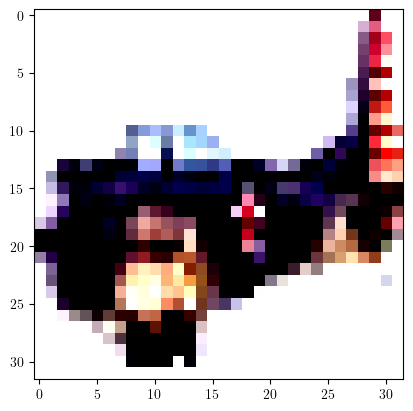

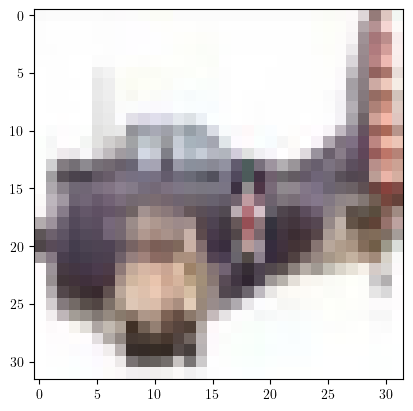

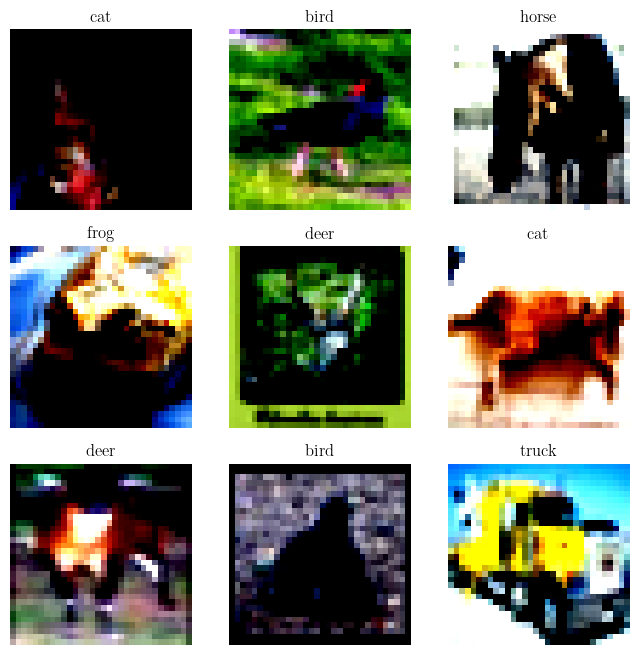

In [7]:
plt.imshow(train_ds[0][0].permute(1, 2, 0))
plt.show()

plt.imshow(train_ds.raw_imgs[0])
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(len(train_ds), size=(1,)).item())
    label = int(train_ds[sample_idx][1].item())
    img = train_ds[sample_idx][0].permute(1, 2, 0).clamp(0, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
from utils.models import VGG19
from utils.training import Trainer
from torch.optim import SGD, Adam
from utils.models import ResNet18, init_kaiming
from torch.optim.lr_scheduler import StepLR
from utils.models import ResNet50
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CosineAnnealingLR
from utils.training import test_model

In [9]:
torch.cuda.empty_cache()

In [10]:
val_loader = DataLoader(
    val_ds, batch_size=2500, num_workers=4, shuffle=False
)

In [52]:
experiment_name = "VGG19-Plain-CEL-Adam"
vgg_plain_cel_adam_model = VGG19(10).to(device)
vgg_plain_cel_adam_model.apply(init_kaiming)

train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg_plain_cel_adam_model.parameters(), lr=0.001)
early_stop = EarlyStopping(
    patience=5, path=f"checkpoints/{experiment_name}.pt"
)

vgg_plain_cel_adam = Trainer(
    experiment_name,
    vgg_plain_cel_adam_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [53]:
vgg_plain_cel_adam.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00100  T_Loss: 2.9538   V_Loss: 4.1602   T_Acc: 0.12   V_Acc: 0.17
Epoch [2/50]  LR: 0.00100  T_Loss: 1.9072   V_Loss: 3.7033   T_Acc: 0.22   V_Acc: 0.26
Epoch [3/50]  LR: 0.00100  T_Loss: 1.7250   V_Loss: 3.3175   T_Acc: 0.31   V_Acc: 0.34
Epoch [4/50]  LR: 0.00100  T_Loss: 1.5051   V_Loss: 2.8267   T_Acc: 0.41   V_Acc: 0.43
Epoch [5/50]  LR: 0.00100  T_Loss: 1.3551   V_Loss: 2.5691   T_Acc: 0.49   V_Acc: 0.53
Epoch [6/50]  LR: 0.00100  T_Loss: 1.1835   V_Loss: 2.2646   T_Acc: 0.58   V_Acc: 0.60
Epoch [7/50]  LR: 0.00100  T_Loss: 1.0282   V_Loss: 2.0468   T_Acc: 0.64   V_Acc: 0.64
EarlyStopping counter: 1 out of 5
Epoch [8/50]  LR: 0.00100  T_Loss: 0.9086   V_Loss: 2.1208   T_Acc: 0.69   V_Acc: 0.65
Epoch [9/50]  LR: 0.00100  T_Loss: 0.8261   V_Loss: 1.8220   T_Acc: 0.72   V_Acc: 0.69
EarlyStopping counter: 1 out of 5
Epoch [10/50]  LR: 0.00100  T_Loss: 0.7340   V_Loss: 1.8291   T_Acc: 0.75   V_Acc: 0.70
Epoch [11/50]  LR: 0.00100  T_Loss: 0.6531   V_Loss: 1.7371  

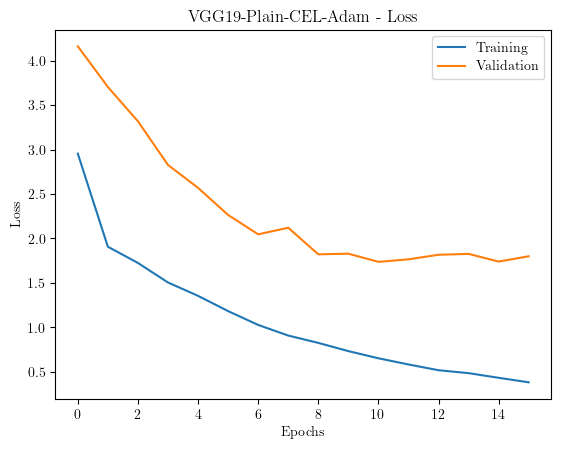

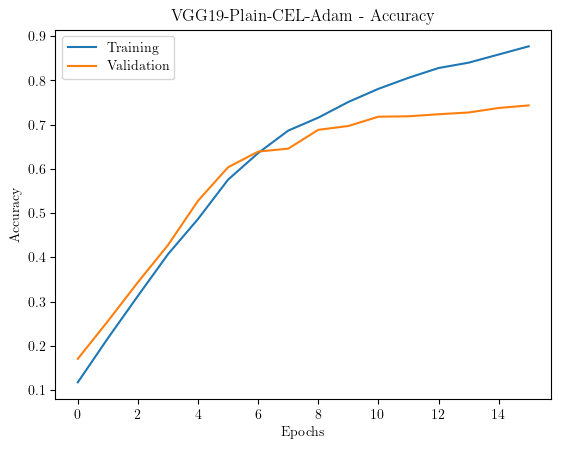

In [54]:
vgg_plain_cel_adam.plot()

In [55]:
experiment_name = "ResNet18-Plain-CEL-Adam"
resnet18_plain_cel_adam_model = ResNet18(10).to(device)
resnet18_plain_cel_adam_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_plain_cel_adam_model.parameters(), lr=0.01)
early_stop = EarlyStopping(
    patience=5, path=f"checkpoints/{experiment_name}.pt"
)

resnet18_plain_cel_adam = Trainer(
    experiment_name,
    resnet18_plain_cel_adam_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [56]:
resnet18_plain_cel_adam.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.8976   V_Loss: 3.4794   T_Acc: 0.37   V_Acc: 0.46
Epoch [2/50]  LR: 0.01000  T_Loss: 1.3615   V_Loss: 2.4470   T_Acc: 0.53   V_Acc: 0.55
EarlyStopping counter: 1 out of 5
Epoch [3/50]  LR: 0.01000  T_Loss: 1.1879   V_Loss: 2.4833   T_Acc: 0.59   V_Acc: 0.58
Epoch [4/50]  LR: 0.01000  T_Loss: 0.9631   V_Loss: 1.9298   T_Acc: 0.66   V_Acc: 0.66
Epoch [5/50]  LR: 0.01000  T_Loss: 0.7997   V_Loss: 1.7829   T_Acc: 0.72   V_Acc: 0.69
Epoch [6/50]  LR: 0.01000  T_Loss: 0.6835   V_Loss: 1.7748   T_Acc: 0.76   V_Acc: 0.69
Epoch [7/50]  LR: 0.01000  T_Loss: 0.5860   V_Loss: 1.7075   T_Acc: 0.79   V_Acc: 0.71
Epoch [8/50]  LR: 0.01000  T_Loss: 0.4943   V_Loss: 1.6779   T_Acc: 0.83   V_Acc: 0.73
EarlyStopping counter: 1 out of 5
Epoch [9/50]  LR: 0.01000  T_Loss: 0.4078   V_Loss: 1.7602   T_Acc: 0.86   V_Acc: 0.72
EarlyStopping counter: 2 out of 5
Epoch [10/50]  LR: 0.01000  T_Loss: 0.3383   V_Loss: 1.8061   T_Acc: 0.88   V_Acc: 0.73
EarlyStopping counter: 3 ou

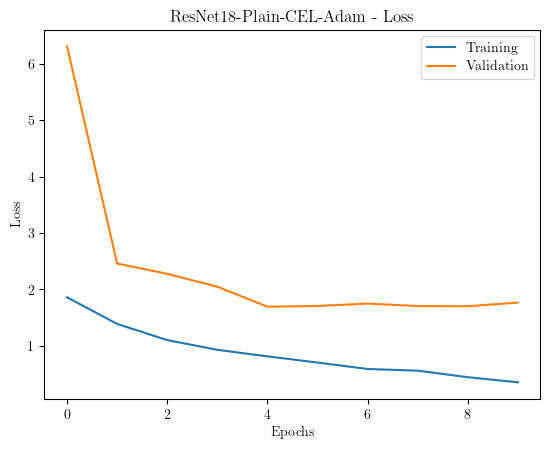

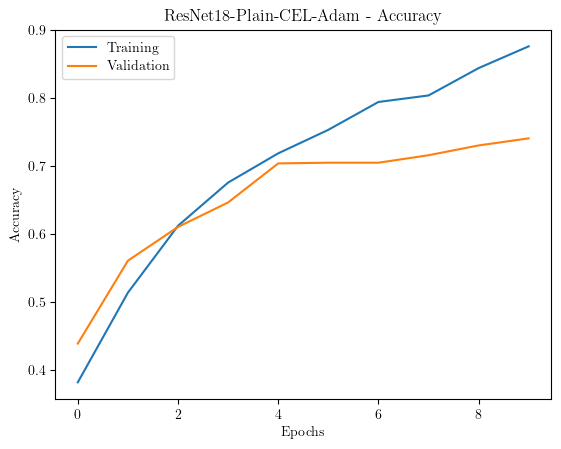

In [66]:
resnet18_plain_cel_adam.plot()

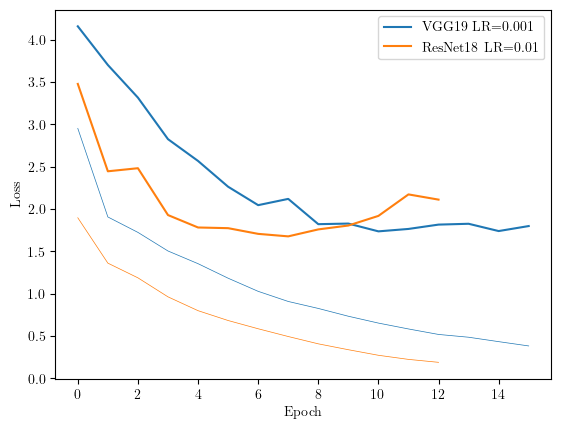

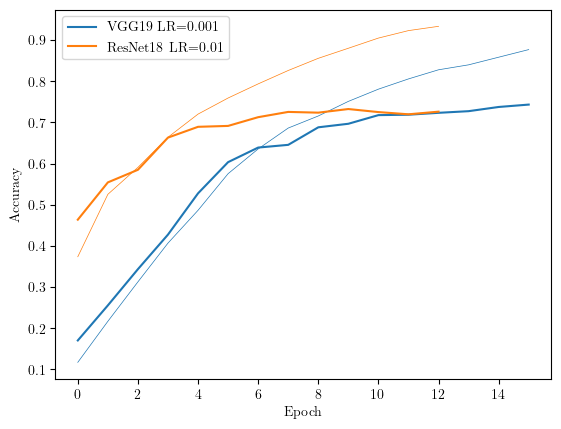

In [64]:
# chart with vgg19 plain and resnet18 plain matching color for tr
plt.plot(vgg_plain_cel_adam.train_losses, color="tab:blue", linewidth=0.5)
plt.plot(resnet18_plain_cel_adam.train_losses, color="tab:orange", linewidth=0.5)
plt.plot(vgg_plain_cel_adam.val_losses, label="VGG19 LR=0.001", color="tab:blue")
plt.plot(resnet18_plain_cel_adam.val_losses, label="ResNet18 LR=0.01", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("docs/plots/init_loss.pdf", format="pdf", dpi=300)
plt.show()

plt.plot(vgg_plain_cel_adam.train_accs, color="tab:blue", linewidth=0.5)
plt.plot(resnet18_plain_cel_adam.train_accs, color="tab:orange", linewidth=0.5)
plt.plot(vgg_plain_cel_adam.val_accs, label="VGG19 LR=0.001", color="tab:blue")
plt.plot(resnet18_plain_cel_adam.val_accs, label="ResNet18 LR=0.01", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("docs/plots/init_acc.pdf", format="pdf", dpi=300)
plt.show()


In [28]:
experiment_name = "VGG19-Plain-CEL-Adam-WeightDecay0.001"
if vgg19_plain_cel_adam_wd1_model is not None:
    del vgg19_plain_cel_adam_wd1_model
vgg19_plain_cel_adam_wd1_model = VGG19(10).to(device)
vgg19_plain_cel_adam_wd1_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg19_plain_cel_adam_wd1_model.parameters(), lr=0.001, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

vgg19_plain_cel_adam_wd1 = Trainer(
    experiment_name,
    vgg19_plain_cel_adam_wd1_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [29]:
vgg19_plain_cel_adam_wd1.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00100  T_Loss: 2.5478   V_Loss: 3.8890   T_Acc: 0.14   V_Acc: 0.19
Epoch [2/50]  LR: 0.00100  T_Loss: 1.8757   V_Loss: 3.5554   T_Acc: 0.22   V_Acc: 0.27
Epoch [3/50]  LR: 0.00100  T_Loss: 1.7081   V_Loss: 3.1911   T_Acc: 0.31   V_Acc: 0.37
Epoch [4/50]  LR: 0.00100  T_Loss: 1.4892   V_Loss: 2.7482   T_Acc: 0.42   V_Acc: 0.48
Epoch [5/50]  LR: 0.00100  T_Loss: 1.3035   V_Loss: 2.3311   T_Acc: 0.51   V_Acc: 0.58
Epoch [6/50]  LR: 0.00100  T_Loss: 1.1487   V_Loss: 2.1356   T_Acc: 0.59   V_Acc: 0.63
Epoch [7/50]  LR: 0.00100  T_Loss: 0.9750   V_Loss: 2.1136   T_Acc: 0.66   V_Acc: 0.64
Epoch [8/50]  LR: 0.00100  T_Loss: 0.8707   V_Loss: 1.8629   T_Acc: 0.70   V_Acc: 0.68
Epoch [9/50]  LR: 0.00100  T_Loss: 0.7642   V_Loss: 1.7215   T_Acc: 0.74   V_Acc: 0.71
Epoch [10/50]  LR: 0.00100  T_Loss: 0.6851   V_Loss: 1.6497   T_Acc: 0.77   V_Acc: 0.73
EarlyStopping counter: 1 out of 10
Epoch [11/50]  LR: 0.00100  T_Loss: 0.6167   V_Loss: 1.6848   T_Acc: 0.80   V_Acc: 0.72
Epoch 

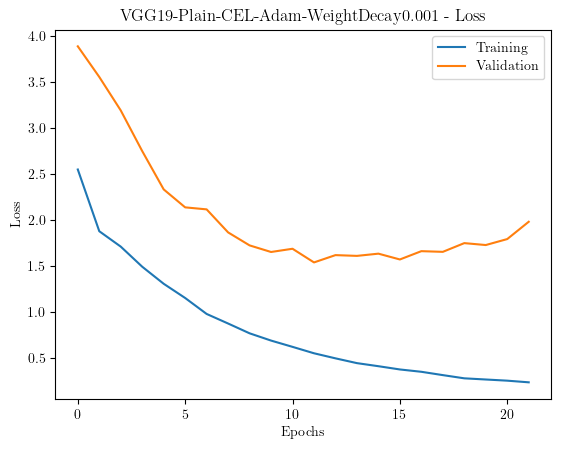

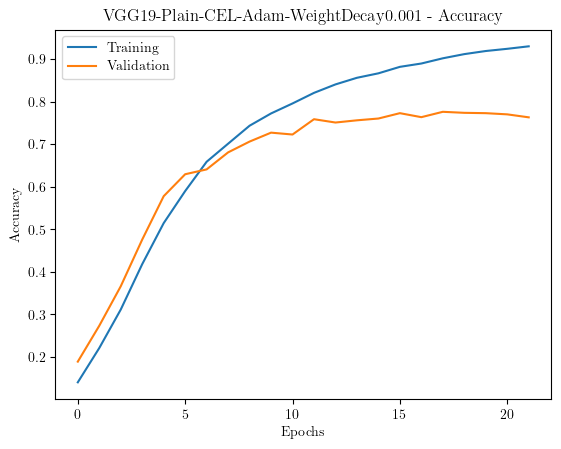

In [30]:
vgg19_plain_cel_adam_wd1.plot()

In [36]:
experiment_name = "ResNet18-Plain-CEL-Adam-WeightDecay0.001"
resnet18_plain_cel_adam_wd1_model = ResNet18(10).to(device)
resnet18_plain_cel_adam_wd1_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_plain_cel_adam_wd1_model.parameters(), lr=0.01, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

resnet18_plain_cel_adam_wd1 = Trainer(
    experiment_name,
    resnet18_plain_cel_adam_wd1_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [37]:
resnet18_plain_cel_adam_wd1.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.9269   V_Loss: 3.0799   T_Acc: 0.36   V_Acc: 0.43
Epoch [2/50]  LR: 0.01000  T_Loss: 1.3789   V_Loss: 2.7977   T_Acc: 0.52   V_Acc: 0.50
Epoch [3/50]  LR: 0.01000  T_Loss: 1.1048   V_Loss: 2.1675   T_Acc: 0.61   V_Acc: 0.61
Epoch [4/50]  LR: 0.01000  T_Loss: 0.9343   V_Loss: 1.9841   T_Acc: 0.67   V_Acc: 0.65
Epoch [5/50]  LR: 0.01000  T_Loss: 0.8498   V_Loss: 1.9015   T_Acc: 0.70   V_Acc: 0.68
EarlyStopping counter: 1 out of 10
Epoch [6/50]  LR: 0.01000  T_Loss: 0.7726   V_Loss: 2.1267   T_Acc: 0.73   V_Acc: 0.65
Epoch [7/50]  LR: 0.01000  T_Loss: 0.7271   V_Loss: 1.7546   T_Acc: 0.75   V_Acc: 0.70
EarlyStopping counter: 1 out of 10
Epoch [8/50]  LR: 0.01000  T_Loss: 0.6839   V_Loss: 1.9210   T_Acc: 0.76   V_Acc: 0.67
Epoch [9/50]  LR: 0.01000  T_Loss: 0.6481   V_Loss: 1.7152   T_Acc: 0.78   V_Acc: 0.71
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 0.6194   V_Loss: 1.7492   T_Acc: 0.79   V_Acc: 0.70
Epoch [11/50]  LR: 0.010

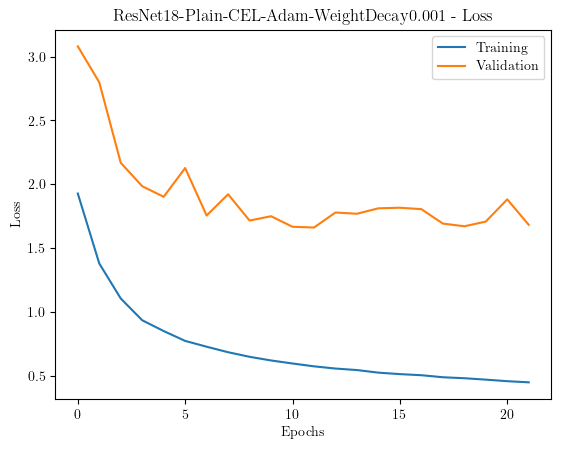

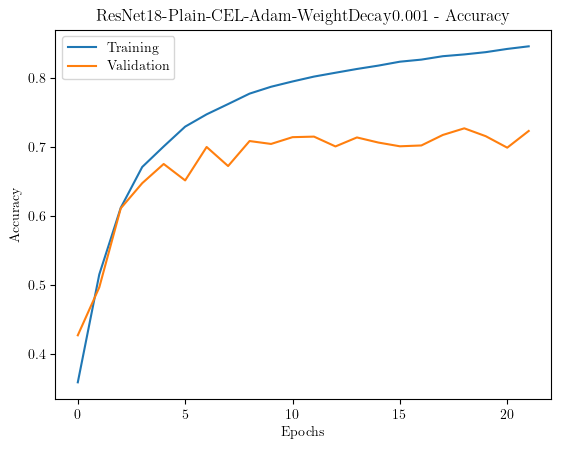

In [ ]:
resnet18_plain_cel_adam_wd1.plot()

In [43]:
experiment_name = "ResNet18-Plain-CEL-Adam-WeightDecay0.005"
resnet18_plain_cel_adam_wd5_model = ResNet18(10).to(device)
resnet18_plain_cel_adam_wd5_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_plain_cel_adam_wd5_model.parameters(), lr=0.01, weight_decay=0.0005)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

resnet18_plain_cel_adam_wd5 = Trainer(
    experiment_name,
    resnet18_plain_cel_adam_wd5_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [44]:
resnet18_plain_cel_adam_wd5.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.9019   V_Loss: 3.5867   T_Acc: 0.36   V_Acc: 0.40
Epoch [2/50]  LR: 0.01000  T_Loss: 1.3395   V_Loss: 3.1974   T_Acc: 0.52   V_Acc: 0.44
Epoch [3/50]  LR: 0.01000  T_Loss: 1.1401   V_Loss: 2.5440   T_Acc: 0.60   V_Acc: 0.58
Epoch [4/50]  LR: 0.01000  T_Loss: 1.0151   V_Loss: 2.1581   T_Acc: 0.64   V_Acc: 0.61
EarlyStopping counter: 1 out of 10
Epoch [5/50]  LR: 0.01000  T_Loss: 0.9571   V_Loss: 2.1686   T_Acc: 0.66   V_Acc: 0.62
Epoch [6/50]  LR: 0.01000  T_Loss: 0.9145   V_Loss: 2.0341   T_Acc: 0.68   V_Acc: 0.65
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.01000  T_Loss: 0.8843   V_Loss: 2.3095   T_Acc: 0.69   V_Acc: 0.61
EarlyStopping counter: 2 out of 10
Epoch [8/50]  LR: 0.01000  T_Loss: 0.8597   V_Loss: 2.3637   T_Acc: 0.70   V_Acc: 0.60
EarlyStopping counter: 3 out of 10
Epoch [9/50]  LR: 0.01000  T_Loss: 0.8464   V_Loss: 2.1858   T_Acc: 0.71   V_Acc: 0.63
EarlyStopping counter: 4 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 0.8186

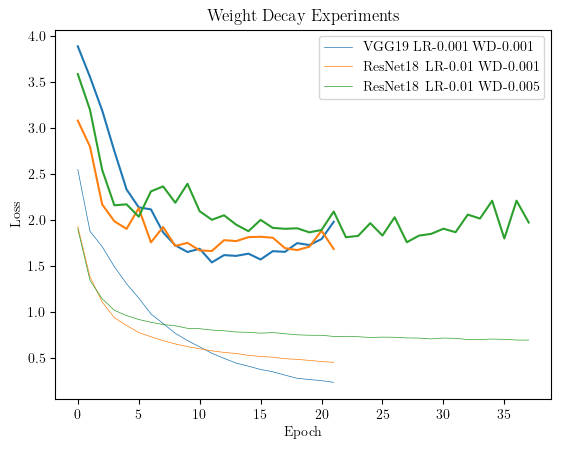

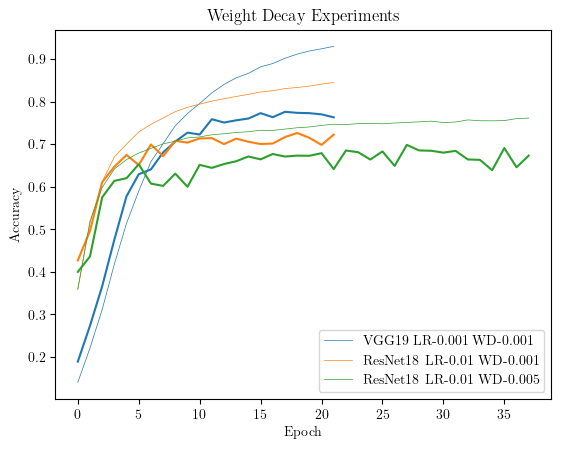

In [65]:
# plot to show all the wegith decay experiments
# train should be thinnner but of the same color as the validation of its experiment


plt.plot(
    vgg19_plain_cel_adam_wd1.train_losses,
    label="VGG19 LR-0.001 WD-0.001",
    color="tab:blue",
    linewidth=0.5,
)
plt.plot(vgg19_plain_cel_adam_wd1.val_losses, color="tab:blue")
plt.plot(
    resnet18_plain_cel_adam_wd1.train_losses,
    label="ResNet18 LR-0.01 WD-0.001",
    color="tab:orange",
    linewidth=0.5,
)
plt.plot(resnet18_plain_cel_adam_wd1.val_losses, color="tab:orange")
plt.plot(
    resnet18_plain_cel_adam_wd5.train_losses,
    label="ResNet18 LR-0.01 WD-0.005",
    color="tab:green",
    linewidth=0.5,
)
plt.plot(resnet18_plain_cel_adam_wd5.val_losses, color="tab:green")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Weight Decay Experiments")
plt.savefig("docs/plots/weight_decay_loss.pdf", format="pdf", dpi=300)
plt.show()

plt.plot(
    vgg19_plain_cel_adam_wd1.train_accs,
    label="VGG19 LR-0.001 WD-0.001",
    color="tab:blue",
    linewidth=0.5,
)
plt.plot(vgg19_plain_cel_adam_wd1.val_accs, color="tab:blue")
plt.plot(
    resnet18_plain_cel_adam_wd1.train_accs,
    label="ResNet18 LR-0.01 WD-0.001",
    color="tab:orange",
    linewidth=0.5,
)
plt.plot(resnet18_plain_cel_adam_wd1.val_accs, color="tab:orange")
plt.plot(
    resnet18_plain_cel_adam_wd5.train_accs,
    label="ResNet18 LR-0.01 WD-0.005",
    color="tab:green",
    linewidth=0.5,
)
plt.plot(resnet18_plain_cel_adam_wd5.val_accs, color="tab:green")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Weight Decay Experiments")
plt.savefig("docs/plots/weight_decay_acc.pdf", format="pdf", dpi=300)
plt.show()

In [12]:
from utils.dataset import CF10FlyAugmentedDataset


train_fly_aug_ds = CF10FlyAugmentedDataset(train_set.imgs, train_set.labels)

In [30]:
experiment_name = "VGG19-Aug-CEL-Adam-WeightDecay0.001"
vgg19_aug_cel_adam_wd1_model = VGG19(10).to(device)
vgg19_aug_cel_adam_wd1_model.apply(init_kaiming)

train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg19_aug_cel_adam_wd1_model.parameters(), lr=0.0001, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

vgg19_aug_cel_adam_wd1 = Trainer(
    experiment_name,
    vgg19_aug_cel_adam_wd1_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [31]:
vgg19_aug_cel_adam_wd1.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00010  T_Loss: 2.1226   V_Loss: 3.5728   T_Acc: 0.18   V_Acc: 0.30
Epoch [2/50]  LR: 0.00010  T_Loss: 1.7845   V_Loss: 3.1596   T_Acc: 0.32   V_Acc: 0.40
Epoch [3/50]  LR: 0.00010  T_Loss: 1.6381   V_Loss: 2.8144   T_Acc: 0.38   V_Acc: 0.48
EarlyStopping counter: 1 out of 10
Epoch [4/50]  LR: 0.00010  T_Loss: 1.5472   V_Loss: 2.8587   T_Acc: 0.43   V_Acc: 0.48
Epoch [5/50]  LR: 0.00010  T_Loss: 1.4658   V_Loss: 2.5376   T_Acc: 0.46   V_Acc: 0.54
Epoch [6/50]  LR: 0.00010  T_Loss: 1.4073   V_Loss: 2.4869   T_Acc: 0.49   V_Acc: 0.55
Epoch [7/50]  LR: 0.00010  T_Loss: 1.3519   V_Loss: 2.3514   T_Acc: 0.51   V_Acc: 0.57
Epoch [8/50]  LR: 0.00010  T_Loss: 1.3201   V_Loss: 2.2827   T_Acc: 0.52   V_Acc: 0.59
Epoch [9/50]  LR: 0.00010  T_Loss: 1.2744   V_Loss: 2.2390   T_Acc: 0.54   V_Acc: 0.59
Epoch [10/50]  LR: 0.00010  T_Loss: 1.2395   V_Loss: 2.1473   T_Acc: 0.56   V_Acc: 0.61
Epoch [11/50]  LR: 0.00010  T_Loss: 1.2123   V_Loss: 2.1010   T_Acc: 0.57   V_Acc: 0.62
Epoch 

In [36]:
experiment_name = "ResNet18-Aug-CEL-Adam-WeightDecay0.001"
resnet18_aug_cel_adam_wd1_model = ResNet18(10).to(device)
resnet18_aug_cel_adam_wd1_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_aug_cel_adam_wd1_model.parameters(), lr=0.01, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

resnet18_aug_cel_adam_wd1 = Trainer(
    experiment_name,
    resnet18_aug_cel_adam_wd1_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [37]:
resnet18_aug_cel_adam_wd1.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.2308   V_Loss: 3.6110   T_Acc: 0.26   V_Acc: 0.34
EarlyStopping counter: 1 out of 10
Epoch [2/50]  LR: 0.01000  T_Loss: 1.7580   V_Loss: 4.1615   T_Acc: 0.36   V_Acc: 0.41
Epoch [3/50]  LR: 0.01000  T_Loss: 1.6490   V_Loss: 2.9413   T_Acc: 0.40   V_Acc: 0.47
Epoch [4/50]  LR: 0.01000  T_Loss: 1.5245   V_Loss: 2.8159   T_Acc: 0.45   V_Acc: 0.51
EarlyStopping counter: 1 out of 10
Epoch [5/50]  LR: 0.01000  T_Loss: 1.4491   V_Loss: 2.9905   T_Acc: 0.48   V_Acc: 0.50
Epoch [6/50]  LR: 0.01000  T_Loss: 1.3739   V_Loss: 2.6672   T_Acc: 0.50   V_Acc: 0.53
Epoch [7/50]  LR: 0.01000  T_Loss: 1.3155   V_Loss: 2.5644   T_Acc: 0.53   V_Acc: 0.55
Epoch [8/50]  LR: 0.01000  T_Loss: 1.2690   V_Loss: 2.4489   T_Acc: 0.55   V_Acc: 0.57
Epoch [9/50]  LR: 0.01000  T_Loss: 1.2236   V_Loss: 2.3031   T_Acc: 0.56   V_Acc: 0.59
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 1.1961   V_Loss: 2.3818   T_Acc: 0.57   V_Acc: 0.60
Epoch [11/50]  LR: 0.010

In [38]:
experiment_name = "ResNet18-Aug-CEL-Adam-WeightDecay0.005"
resnet18_aug_cel_adam_wd5_model = ResNet18(10).to(device)
resnet18_aug_cel_adam_wd5_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_aug_cel_adam_wd5_model.parameters(), lr=0.01, weight_decay=0.0005)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)

resnet18_aug_cel_adam_wd5 = Trainer(
    experiment_name,
    resnet18_aug_cel_adam_wd5_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
)

In [39]:
resnet18_aug_cel_adam_wd5.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.1737   V_Loss: 3.4939   T_Acc: 0.28   V_Acc: 0.34
Epoch [2/50]  LR: 0.01000  T_Loss: 1.8357   V_Loss: 3.2912   T_Acc: 0.33   V_Acc: 0.40
Epoch [3/50]  LR: 0.01000  T_Loss: 1.6305   V_Loss: 2.9560   T_Acc: 0.40   V_Acc: 0.45
Epoch [4/50]  LR: 0.01000  T_Loss: 1.5354   V_Loss: 2.9389   T_Acc: 0.43   V_Acc: 0.47
EarlyStopping counter: 1 out of 10
Epoch [5/50]  LR: 0.01000  T_Loss: 1.4811   V_Loss: 3.0038   T_Acc: 0.46   V_Acc: 0.46
Epoch [6/50]  LR: 0.01000  T_Loss: 1.4172   V_Loss: 2.4990   T_Acc: 0.49   V_Acc: 0.56
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.01000  T_Loss: 1.3880   V_Loss: 3.0073   T_Acc: 0.50   V_Acc: 0.50
Epoch [8/50]  LR: 0.01000  T_Loss: 1.3522   V_Loss: 2.4768   T_Acc: 0.51   V_Acc: 0.55
EarlyStopping counter: 1 out of 10
Epoch [9/50]  LR: 0.01000  T_Loss: 1.3335   V_Loss: 2.5133   T_Acc: 0.52   V_Acc: 0.54
EarlyStopping counter: 2 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 1.3093   V_Loss: 2.5580   T_Acc: 0.53   V

In [32]:
experiment_name = "VGG19-Aug-CEL-Adam-WeightDecay0.001-StepLR"
vgg19_aug_cel_adam_wd1_steplr_model = VGG19(10).to(device)
vgg19_aug_cel_adam_wd1_steplr_model.apply(init_kaiming)

train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg19_aug_cel_adam_wd1_steplr_model.parameters(), lr=0.0001, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)
scheduler = StepLR(optimizer, step_size=45, gamma=0.1)

vgg19_aug_cel_adam_wd1_steplr = Trainer(
    experiment_name,
    vgg19_aug_cel_adam_wd1_steplr_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [33]:
vgg19_aug_cel_adam_wd1_steplr.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00010  T_Loss: 2.1180   V_Loss: 3.5581   T_Acc: 0.19   V_Acc: 0.32
Epoch [2/50]  LR: 0.00010  T_Loss: 1.7720   V_Loss: 3.1766   T_Acc: 0.33   V_Acc: 0.41
Epoch [3/50]  LR: 0.00010  T_Loss: 1.6332   V_Loss: 2.8884   T_Acc: 0.39   V_Acc: 0.46
Epoch [4/50]  LR: 0.00010  T_Loss: 1.5418   V_Loss: 2.8233   T_Acc: 0.43   V_Acc: 0.47
Epoch [5/50]  LR: 0.00010  T_Loss: 1.4671   V_Loss: 2.6281   T_Acc: 0.46   V_Acc: 0.52
Epoch [6/50]  LR: 0.00010  T_Loss: 1.4166   V_Loss: 2.4988   T_Acc: 0.48   V_Acc: 0.55
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.00010  T_Loss: 1.3833   V_Loss: 2.5812   T_Acc: 0.50   V_Acc: 0.53
Epoch [8/50]  LR: 0.00010  T_Loss: 1.3322   V_Loss: 2.3282   T_Acc: 0.51   V_Acc: 0.57
EarlyStopping counter: 1 out of 10
Epoch [9/50]  LR: 0.00010  T_Loss: 1.2993   V_Loss: 2.3354   T_Acc: 0.53   V_Acc: 0.58
Epoch [10/50]  LR: 0.00010  T_Loss: 1.2576   V_Loss: 2.2202   T_Acc: 0.55   V_Acc: 0.60
Epoch [11/50]  LR: 0.00010  T_Loss: 1.2298   V_Loss: 2.1170

In [34]:
vgg19_aug_cel_adam_wd1_steplr.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00001  T_Loss: 0.5054   V_Loss: 1.0803   T_Acc: 0.82   V_Acc: 0.82
EarlyStopping counter: 1 out of 10
Epoch [2/50]  LR: 0.00001  T_Loss: 0.5050   V_Loss: 1.0857   T_Acc: 0.82   V_Acc: 0.82
EarlyStopping counter: 2 out of 10
Epoch [3/50]  LR: 0.00001  T_Loss: 0.4957   V_Loss: 1.0869   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 3 out of 10
Epoch [4/50]  LR: 0.00001  T_Loss: 0.4985   V_Loss: 1.0830   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 4 out of 10
Epoch [5/50]  LR: 0.00001  T_Loss: 0.4968   V_Loss: 1.0848   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 5 out of 10
Epoch [6/50]  LR: 0.00001  T_Loss: 0.4907   V_Loss: 1.1008   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 6 out of 10
Epoch [7/50]  LR: 0.00001  T_Loss: 0.4883   V_Loss: 1.0823   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 7 out of 10
Epoch [8/50]  LR: 0.00001  T_Loss: 0.4822   V_Loss: 1.0896   T_Acc: 0.83   V_Acc: 0.82
EarlyStopping counter: 8 out of 10
Epoch [9/50]  LR: 0.0000

In [17]:
experiment_name = "ResNet18-Aug-CEL-Adam-WeightDecay0.001-StepLR15-0.1"
resnet18_aug_cel_adam_wd1_steplr_model = ResNet18(10).to(device)
resnet18_aug_cel_adam_wd1_steplr_model.apply(init_kaiming)

train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_aug_cel_adam_wd1_steplr_model.parameters(), lr=0.01, weight_decay=0.0001)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

resnet18_aug_cel_adam_wd1_steplr = Trainer(
    experiment_name,
    resnet18_aug_cel_adam_wd1_steplr_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [18]:
resnet18_aug_cel_adam_wd1_steplr.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.1498   V_Loss: 3.6649   T_Acc: 0.26   V_Acc: 0.33
Epoch [2/50]  LR: 0.01000  T_Loss: 1.7714   V_Loss: 3.2913   T_Acc: 0.37   V_Acc: 0.40
EarlyStopping counter: 1 out of 10
Epoch [3/50]  LR: 0.01000  T_Loss: 1.6302   V_Loss: 168.9880   T_Acc: 0.41   V_Acc: 0.25
Epoch [4/50]  LR: 0.01000  T_Loss: 1.5626   V_Loss: 2.6881   T_Acc: 0.44   V_Acc: 0.51
Epoch [5/50]  LR: 0.01000  T_Loss: 1.4427   V_Loss: 2.6781   T_Acc: 0.48   V_Acc: 0.52
Epoch [6/50]  LR: 0.01000  T_Loss: 1.3596   V_Loss: 2.4661   T_Acc: 0.51   V_Acc: 0.56
Epoch [7/50]  LR: 0.01000  T_Loss: 1.2969   V_Loss: 2.2504   T_Acc: 0.54   V_Acc: 0.60
Epoch [8/50]  LR: 0.01000  T_Loss: 1.2608   V_Loss: 2.1667   T_Acc: 0.55   V_Acc: 0.60
Epoch [9/50]  LR: 0.01000  T_Loss: 1.2178   V_Loss: 2.1611   T_Acc: 0.56   V_Acc: 0.63
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 1.1990   V_Loss: 2.4923   T_Acc: 0.57   V_Acc: 0.56
Epoch [11/50]  LR: 0.01000  T_Loss: 1.1686   V_Loss: 2.10

In [78]:
# resnet18_aug_cel_adam_wd1_steplr = resnet18_aug_cel_adam_wd1

In [19]:
experiment_name = "ResNet18-Aug-CEL-Adam-WeightDecay0.005-StepLR15-0.1"
resnet18_aug_cel_adam_wd5_steplr_model = ResNet18(10).to(device)
resnet18_aug_cel_adam_wd5_steplr_model.apply(init_kaiming)

del train_loader
train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet18_aug_cel_adam_wd5_steplr_model.parameters(), lr=0.01, weight_decay=0.0005)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}.pt"
)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

resnet18_aug_cel_adam_wd5_steplr = Trainer(
    experiment_name,
    resnet18_aug_cel_adam_wd5_steplr_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [20]:
resnet18_aug_cel_adam_wd5_steplr.fit(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.1710   V_Loss: 3.4232   T_Acc: 0.26   V_Acc: 0.37
Epoch [2/50]  LR: 0.01000  T_Loss: 1.6981   V_Loss: 3.3379   T_Acc: 0.38   V_Acc: 0.37
Epoch [3/50]  LR: 0.01000  T_Loss: 1.5854   V_Loss: 3.1885   T_Acc: 0.42   V_Acc: 0.42
Epoch [4/50]  LR: 0.01000  T_Loss: 1.4939   V_Loss: 2.7137   T_Acc: 0.45   V_Acc: 0.50
Epoch [5/50]  LR: 0.01000  T_Loss: 1.4275   V_Loss: 2.6157   T_Acc: 0.48   V_Acc: 0.52
EarlyStopping counter: 1 out of 10
Epoch [6/50]  LR: 0.01000  T_Loss: 1.3906   V_Loss: 2.9523   T_Acc: 0.50   V_Acc: 0.49
EarlyStopping counter: 2 out of 10
Epoch [7/50]  LR: 0.01000  T_Loss: 1.3649   V_Loss: 2.7576   T_Acc: 0.51   V_Acc: 0.51
Epoch [8/50]  LR: 0.01000  T_Loss: 1.3374   V_Loss: 2.4858   T_Acc: 0.52   V_Acc: 0.54
EarlyStopping counter: 1 out of 10
Epoch [9/50]  LR: 0.01000  T_Loss: 1.3238   V_Loss: 2.6180   T_Acc: 0.52   V_Acc: 0.54
Epoch [10/50]  LR: 0.01000  T_Loss: 1.3059   V_Loss: 2.4170   T_Acc: 0.53   V_Acc: 0.58
Epoch [11/50]  LR: 0.010

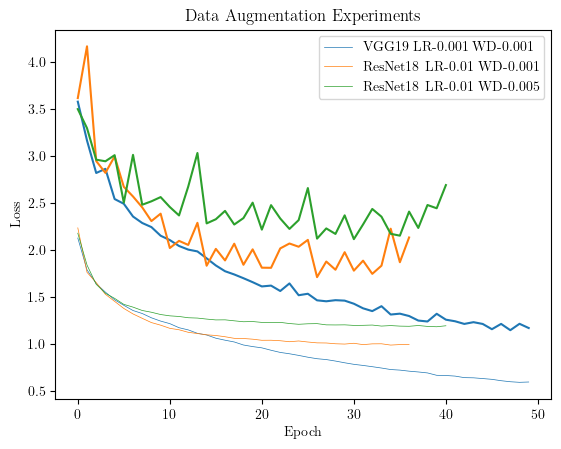

In [40]:
plt.plot(
    vgg19_aug_cel_adam_wd1.train_losses,
    label="VGG19 LR-0.001 WD-0.001",
    color="tab:blue",
    linewidth=0.5,
)
plt.plot(vgg19_aug_cel_adam_wd1.val_losses, color="tab:blue")
plt.plot(
    resnet18_aug_cel_adam_wd1.train_losses,
    label="ResNet18 LR-0.01 WD-0.001",
    color="tab:orange",
    linewidth=0.5,
)
plt.plot(resnet18_aug_cel_adam_wd1.val_losses, color="tab:orange")
plt.plot(
    resnet18_aug_cel_adam_wd5.train_losses,
    label="ResNet18 LR-0.01 WD-0.005",
    color="tab:green",
    linewidth=0.5,
)
plt.plot(resnet18_aug_cel_adam_wd5.val_losses, color="tab:green")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Data Augmentation Experiments")
plt.savefig("docs/plots/weight_decay_loss_aug.pdf", format="pdf", dpi=300)
plt.show()

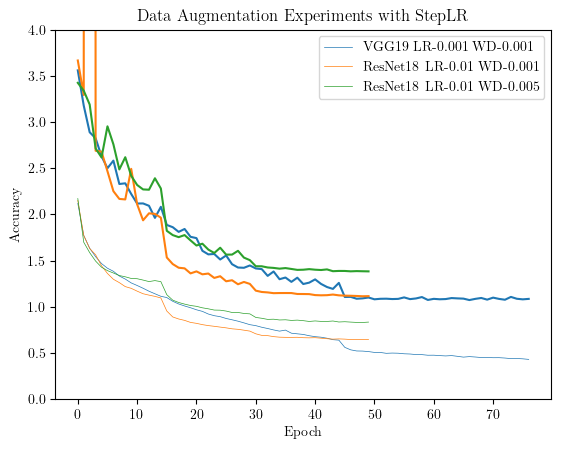

In [41]:
plt.plot(
    vgg19_aug_cel_adam_wd1_steplr.train_losses,
    label="VGG19 LR-0.001 WD-0.001",
    color="tab:blue",
    linewidth=0.5,
)
plt.plot(vgg19_aug_cel_adam_wd1_steplr.val_losses, color="tab:blue")
plt.plot(
    resnet18_aug_cel_adam_wd1_steplr.train_losses,
    label="ResNet18 LR-0.01 WD-0.001",
    color="tab:orange",
    linewidth=0.5,
)
plt.plot(resnet18_aug_cel_adam_wd1_steplr.val_losses, color="tab:orange")
plt.plot(
    resnet18_aug_cel_adam_wd5_steplr.train_losses,
    label="ResNet18 LR-0.01 WD-0.005",
    color="tab:green",
    linewidth=0.5,
)
plt.plot(resnet18_aug_cel_adam_wd5_steplr.val_losses, color="tab:green")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Data Augmentation Experiments with StepLR")
plt.ylim(0, 4)
plt.savefig("docs/plots/weight_decay_acc_aug_steplr.pdf", format="pdf", dpi=300)
plt.show()


In [42]:
test_loader = DataLoader(test_ds, batch_size=2500, num_workers=4, shuffle=False)

In [45]:
checkpoint = torch.load("checkpoints/VGG19-Aug-CEL-Adam-WeightDecay0.001-StepLR.pt")
vgg19_aug_cel_adam_wd1_steplr_model.load_state_dict(checkpoint)
vgg19_aug_cel_adam_wd1_steplr_model.eval()
test_model(vgg19_aug_cel_adam_wd1_steplr_model, test_loader)

/tmp/ipykernel_476071/3769507252.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/VGG19-Aug-CEL-Adam-WeightDecay0.001-StepLR.pt")


Accuracy: 82.43 %


In [46]:
checkpoint = torch.load("checkpoints/ResNet18-Aug-CEL-Adam-WeightDecay0.001-StepLR15-0.1.pt")
resnet18_aug_cel_adam_wd1_steplr_model.load_state_dict(checkpoint)
resnet18_aug_cel_adam_wd1_steplr_model.eval()
test_model(resnet18_aug_cel_adam_wd1_steplr_model, test_loader)

/tmp/ipykernel_476071/4230756526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/ResNet18-Aug-CEL-Adam-WeightDecay0.001-StepLR15-0.1

Accuracy: 81.58 %


### Below here is not part of the report

In [37]:
experiment_name = "VGG19-Plain-CEL-SGD"
vgg19_plain_cel_sgd_model = VGG19(10).to(device)
vgg19_plain_cel_sgd_model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(vgg19_plain_cel_sgd_model.parameters(), lr=0.01, momentum=0.9)
early_stop = EarlyStopping(patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt")

vgg19_plain_cel_sgd = Trainer(
    experiment_name, vgg19_plain_cel_sgd_model, train_loader, val_loader, optimizer, criterion, early_stop
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.0208   V_Loss: 3.3284   T_Acc: 0.22   V_Acc: 0.37
Epoch [2/50]  LR: 0.01000  T_Loss: 1.5630   V_Loss: 2.8315   T_Acc: 0.40   V_Acc: 0.47
Epoch [3/50]  LR: 0.01000  T_Loss: 1.3202   V_Loss: 2.6250   T_Acc: 0.51   V_Acc: 0.53
Epoch [4/50]  LR: 0.01000  T_Loss: 1.1253   V_Loss: 2.2955   T_Acc: 0.60   V_Acc: 0.59
Epoch [5/50]  LR: 0.01000  T_Loss: 0.9578   V_Loss: 1.8669   T_Acc: 0.66   V_Acc: 0.67
Epoch [6/50]  LR: 0.01000  T_Loss: 0.8206   V_Loss: 1.7479   T_Acc: 0.71   V_Acc: 0.69
Epoch [7/50]  LR: 0.01000  T_Loss: 0.7076   V_Loss: 1.6714   T_Acc: 0.76   V_Acc: 0.72
Epoch [8/50]  LR: 0.01000  T_Loss: 0.6132   V_Loss: 1.6388   T_Acc: 0.79   V_Acc: 0.73
Epoch [9/50]  LR: 0.01000  T_Loss: 0.5337   V_Loss: 1.5556   T_Acc: 0.82   V_Acc: 0.75
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 0.4653   V_Loss: 1.6058   T_Acc: 0.84   V_Acc: 0.75
Epoch [11/50]  LR: 0.01000  T_Loss: 0.3858   V_Loss: 1.4976   T_Acc: 0.87   V_Acc: 0.76
EarlyS

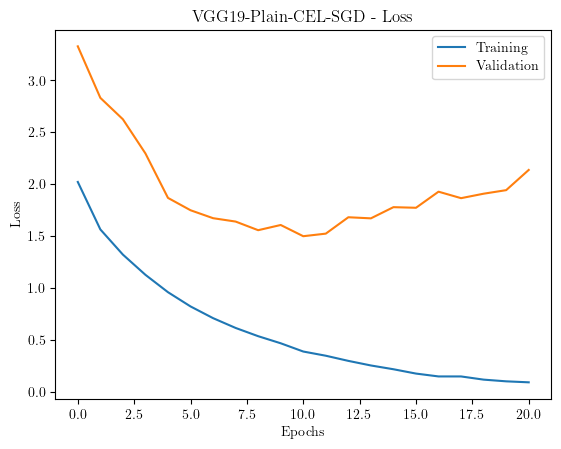

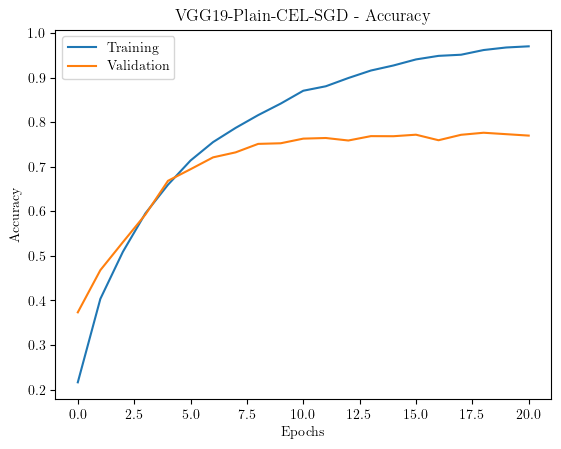

In [38]:
vgg19_plain_cel_sgd.fit(50)
vgg19_plain_cel_sgd.plot()

In [40]:
experiment_name = "VGG19-Plain-CEL-SGD-WeightDecay"
vgg19_plain_cel_sgd_wd_model = VGG19(10).to(device)
vgg19_plain_cel_sgd_wd_model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(vgg19_plain_cel_sgd_wd_model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
early_stop = EarlyStopping(patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt")

vgg19_plain_cel_sgd_wd = Trainer(
    experiment_name, vgg19_plain_cel_sgd_wd_model, train_loader, val_loader, optimizer, criterion, early_stop
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.1284   V_Loss: 3.7646   T_Acc: 0.19   V_Acc: 0.27
Epoch [2/50]  LR: 0.01000  T_Loss: 1.7322   V_Loss: 3.0722   T_Acc: 0.33   V_Acc: 0.42
Epoch [3/50]  LR: 0.01000  T_Loss: 1.4637   V_Loss: 2.7797   T_Acc: 0.45   V_Acc: 0.49
Epoch [4/50]  LR: 0.01000  T_Loss: 1.2307   V_Loss: 2.2840   T_Acc: 0.55   V_Acc: 0.59
Epoch [5/50]  LR: 0.01000  T_Loss: 1.0415   V_Loss: 1.9858   T_Acc: 0.62   V_Acc: 0.65
Epoch [6/50]  LR: 0.01000  T_Loss: 0.9200   V_Loss: 1.8623   T_Acc: 0.67   V_Acc: 0.67
Epoch [7/50]  LR: 0.01000  T_Loss: 0.8011   V_Loss: 1.8412   T_Acc: 0.72   V_Acc: 0.69
Epoch [8/50]  LR: 0.01000  T_Loss: 0.7029   V_Loss: 1.6128   T_Acc: 0.75   V_Acc: 0.71
Epoch [9/50]  LR: 0.01000  T_Loss: 0.6168   V_Loss: 1.5437   T_Acc: 0.79   V_Acc: 0.74
Epoch [10/50]  LR: 0.01000  T_Loss: 0.5340   V_Loss: 1.5091   T_Acc: 0.82   V_Acc: 0.75
EarlyStopping counter: 1 out of 10
Epoch [11/50]  LR: 0.01000  T_Loss: 0.4752   V_Loss: 1.5987   T_Acc: 0.84   V_Acc: 0.75
EarlyS

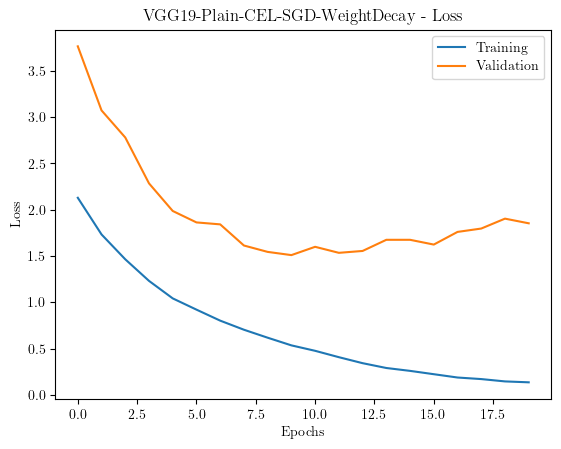

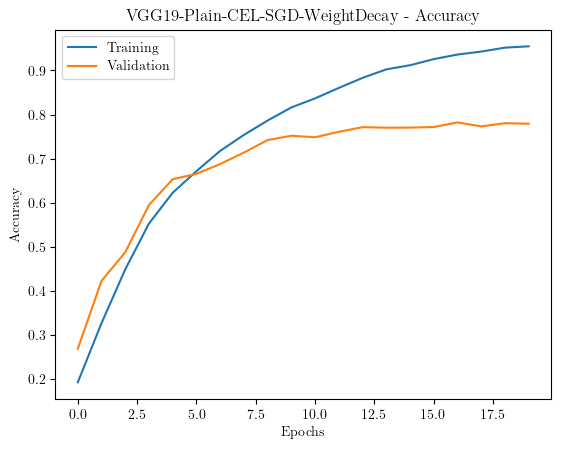

In [41]:
vgg19_plain_cel_sgd_wd.fit(50)
vgg19_plain_cel_sgd_wd.plot()

In [43]:
experiment_name = "VGG19-Plain-CEL-SGD-WeightDecay"
vgg19_plain_cel_sgd_wd_model = VGG19(10).to(device)
vgg19_plain_cel_sgd_wd_model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(
    vgg19_plain_cel_sgd_wd_model.parameters(),
    lr=0.01,
    weight_decay=0.0005,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

vgg19_plain_cel_sgd_wd = Trainer(
    experiment_name,
    vgg19_plain_cel_sgd_wd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [44]:
vgg19_plain_cel_sgd_wd.fit(50)
vgg19_plain_cel_sgd_wd.plot()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 2.0143   V_Loss: 3.3101   T_Acc: 0.23   V_Acc: 0.35
Epoch [2/50]  LR: 0.01000  T_Loss: 1.5411   V_Loss: 2.6925   T_Acc: 0.42   V_Acc: 0.50
Epoch [3/50]  LR: 0.01000  T_Loss: 1.2924   V_Loss: 2.3921   T_Acc: 0.52   V_Acc: 0.56
Epoch [4/50]  LR: 0.01000  T_Loss: 1.0996   V_Loss: 1.9732   T_Acc: 0.60   V_Acc: 0.65
Epoch [5/50]  LR: 0.01000  T_Loss: 0.9302   V_Loss: 1.7840   T_Acc: 0.67   V_Acc: 0.68
Epoch [6/50]  LR: 0.00100  T_Loss: 0.6771   V_Loss: 1.6056   T_Acc: 0.76   V_Acc: 0.72
Epoch [7/50]  LR: 0.00100  T_Loss: 0.6073   V_Loss: 1.5580   T_Acc: 0.79   V_Acc: 0.73
EarlyStopping counter: 1 out of 10
Epoch [8/50]  LR: 0.00100  T_Loss: 0.5586   V_Loss: 1.5740   T_Acc: 0.81   V_Acc: 0.74
EarlyStopping counter: 2 out of 10
Epoch [9/50]  LR: 0.00100  T_Loss: 0.5080   V_Loss: 1.5633   T_Acc: 0.82   V_Acc: 0.74
EarlyStopping counter: 3 out of 10
Epoch [10/50]  LR: 0.00100  T_Loss: 0.4507   V_Loss: 1.5895   T_Acc: 0.85   V_Acc: 0.74
EarlyStopping counter: 4

In [55]:
experiment_name = "VGG19-Aug3-CEL-SGD-WeightDecay"
vgg19_aug3_cel_sgd_wd_model = VGG19(10).to(device)
vgg19_aug3_cel_sgd_wd_model.apply(init_weights)

del train_loader
train_loader = DataLoader(train_aug_3_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(
    vgg19_aug3_cel_sgd_wd_model.parameters(),
    lr=0.01,
    weight_decay=0.0005,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

vgg19_aug3_cel_sgd_wd = Trainer(
    experiment_name,
    vgg19_aug3_cel_sgd_wd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [56]:
vgg19_aug3_cel_sgd_wd.fit(50)
vgg19_aug3_cel_sgd_wd.plot()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
experiment_name = "VGG19-Aug10-CEL-SGD-WeightDecay"
vgg19_aug10_cel_sgd_wd_model = VGG19(10).to(device)
vgg19_aug10_cel_sgd_wd_model.apply(init_weights)

del train_loader
train_loader = DataLoader(train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(
    vgg19_aug10_cel_sgd_wd_model.parameters(),
    lr=0.01,
    weight_decay=0.0005,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

vgg19_aug10_cel_sgd_wd = Trainer(
    experiment_name,
    vgg19_aug10_cel_sgd_wd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.4143   V_Loss: 1.6900   T_Acc: 0.48   V_Acc: 0.70
Epoch [2/50]  LR: 0.01000  T_Loss: 0.8137   V_Loss: 1.1245   T_Acc: 0.72   V_Acc: 0.81
EarlyStopping counter: 1 out of 10
Epoch [3/50]  LR: 0.01000  T_Loss: 0.5864   V_Loss: 1.1394   T_Acc: 0.80   V_Acc: 0.80
Epoch [4/50]  LR: 0.01000  T_Loss: 0.4570   V_Loss: 0.8853   T_Acc: 0.84   V_Acc: 0.85
Epoch [5/50]  LR: 0.01000  T_Loss: 0.3699   V_Loss: 0.8269   T_Acc: 0.87   V_Acc: 0.86
Epoch [6/50]  LR: 0.00100  T_Loss: 0.1742   V_Loss: 0.7775   T_Acc: 0.94   V_Acc: 0.89
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.00100  T_Loss: 0.1278   V_Loss: 0.8281   T_Acc: 0.96   V_Acc: 0.89
EarlyStopping counter: 2 out of 10
Epoch [8/50]  LR: 0.00100  T_Loss: 0.0967   V_Loss: 0.9113   T_Acc: 0.97   V_Acc: 0.89
EarlyStopping counter: 3 out of 10
Epoch [9/50]  LR: 0.00100  T_Loss: 0.0708   V_Loss: 0.9910   T_Acc: 0.98   V_Acc: 0.89
EarlyStopping counter: 4 out of 10
Epoch [10/50]  LR: 0.00100  T_Loss: 0.0492

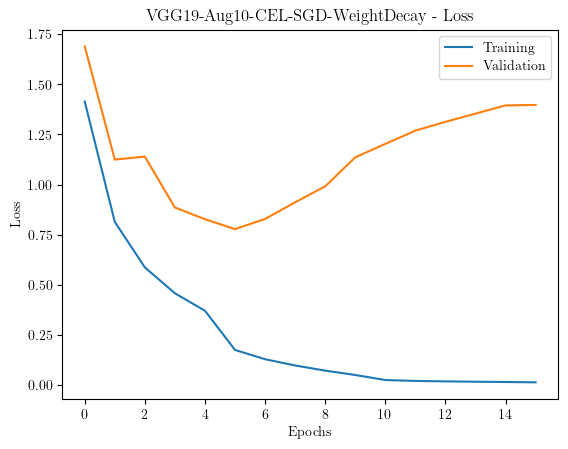

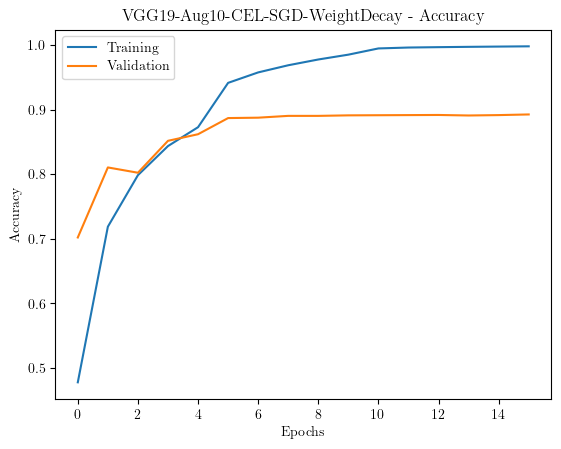

In [58]:
vgg19_aug10_cel_sgd_wd.fit(50)
vgg19_aug10_cel_sgd_wd.plot()

In [59]:
experiment_name = "VGG19-Aug10-CEL-SGD-WeightDecay-LabelSmoothing"
vgg19_aug10_cel_sgd_wd_ls_model = VGG19(10).to(device)
vgg19_aug10_cel_sgd_wd_ls_model.apply(init_weights)

del train_loader
train_loader = DataLoader(train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = SGD(
    vgg19_aug10_cel_sgd_wd_ls_model.parameters(),
    lr=0.01,
    weight_decay=0.0005,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

vgg19_aug10_cel_sgd_wd_ls = Trainer(
    experiment_name,
    vgg19_aug10_cel_sgd_wd_ls_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.6138   V_Loss: 2.3231   T_Acc: 0.48   V_Acc: 0.70
Epoch [2/50]  LR: 0.01000  T_Loss: 1.1466   V_Loss: 1.9643   T_Acc: 0.71   V_Acc: 0.78
Epoch [3/50]  LR: 0.01000  T_Loss: 0.9711   V_Loss: 1.7502   T_Acc: 0.79   V_Acc: 0.84
Epoch [4/50]  LR: 0.01000  T_Loss: 0.8682   V_Loss: 1.6704   T_Acc: 0.84   V_Acc: 0.85
Epoch [5/50]  LR: 0.01000  T_Loss: 0.8005   V_Loss: 1.6587   T_Acc: 0.87   V_Acc: 0.86
Epoch [6/50]  LR: 0.01000  T_Loss: 0.7484   V_Loss: 1.6303   T_Acc: 0.89   V_Acc: 0.87
Epoch [7/50]  LR: 0.01000  T_Loss: 0.7054   V_Loss: 1.6258   T_Acc: 0.91   V_Acc: 0.87
EarlyStopping counter: 1 out of 10
Epoch [8/50]  LR: 0.01000  T_Loss: 0.6758   V_Loss: 1.6372   T_Acc: 0.92   V_Acc: 0.87
Epoch [9/50]  LR: 0.01000  T_Loss: 0.6498   V_Loss: 1.5731   T_Acc: 0.94   V_Acc: 0.89
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 0.6311   V_Loss: 1.6036   T_Acc: 0.94   V_Acc: 0.88
Epoch [11/50]  LR: 0.00100  T_Loss: 0.5417   V_Loss: 1.5363

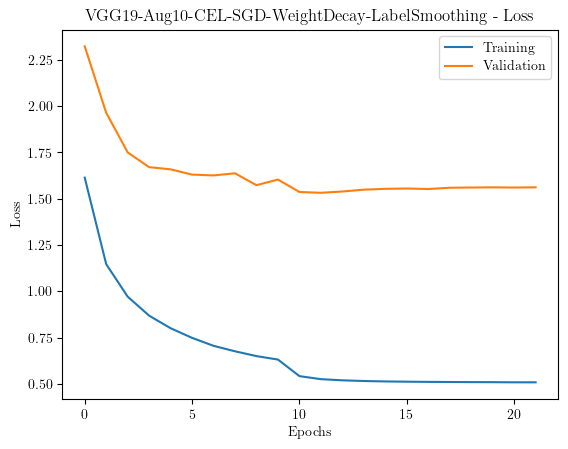

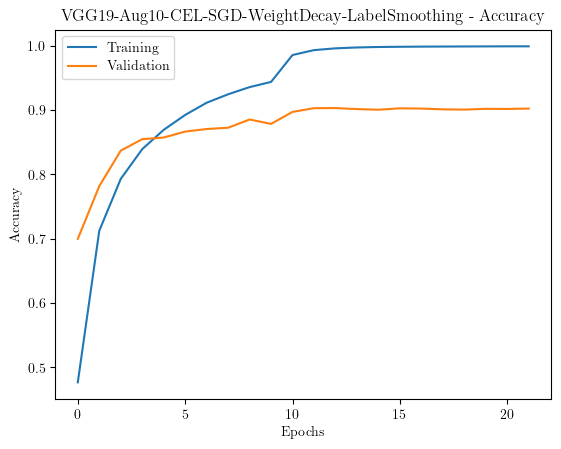

In [60]:
vgg19_aug10_cel_sgd_wd_ls.fit(50)
vgg19_aug10_cel_sgd_wd_ls.plot()

In [62]:
experiment_name = "VGG19-Aug10-CEL-SGD-WeightDecay-LabelSmoothing2"
vgg19_aug10_cel_sgd_wd_ls2_model = VGG19(10).to(device)
vgg19_aug10_cel_sgd_wd_ls2_model.apply(init_weights)

del train_loader
train_loader = DataLoader(train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = SGD(
    vgg19_aug10_cel_sgd_wd_ls2_model.parameters(),
    lr=0.01,
    weight_decay=0.0005,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

vgg19_aug10_cel_sgd_wd_ls2 = Trainer(
    experiment_name,
    vgg19_aug10_cel_sgd_wd_ls2_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.7680   V_Loss: 2.7999   T_Acc: 0.47   V_Acc: 0.70
Epoch [2/50]  LR: 0.01000  T_Loss: 1.3934   V_Loss: 2.4953   T_Acc: 0.71   V_Acc: 0.79
Epoch [3/50]  LR: 0.01000  T_Loss: 1.2565   V_Loss: 2.3594   T_Acc: 0.79   V_Acc: 0.83
Epoch [4/50]  LR: 0.01000  T_Loss: 1.1805   V_Loss: 2.2909   T_Acc: 0.83   V_Acc: 0.85
EarlyStopping counter: 1 out of 10
Epoch [5/50]  LR: 0.01000  T_Loss: 1.1235   V_Loss: 2.3186   T_Acc: 0.86   V_Acc: 0.85
Epoch [6/50]  LR: 0.01000  T_Loss: 1.0832   V_Loss: 2.2692   T_Acc: 0.88   V_Acc: 0.86
Epoch [7/50]  LR: 0.01000  T_Loss: 1.0518   V_Loss: 2.2552   T_Acc: 0.90   V_Acc: 0.86
Epoch [8/50]  LR: 0.01000  T_Loss: 1.0250   V_Loss: 2.2431   T_Acc: 0.92   V_Acc: 0.87
Epoch [9/50]  LR: 0.01000  T_Loss: 1.0041   V_Loss: 2.2018   T_Acc: 0.93   V_Acc: 0.88
EarlyStopping counter: 1 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 0.9883   V_Loss: 2.2104   T_Acc: 0.94   V_Acc: 0.88
Epoch [11/50]  LR: 0.00100  T_Loss: 0.9112   V_Loss: 2.1511

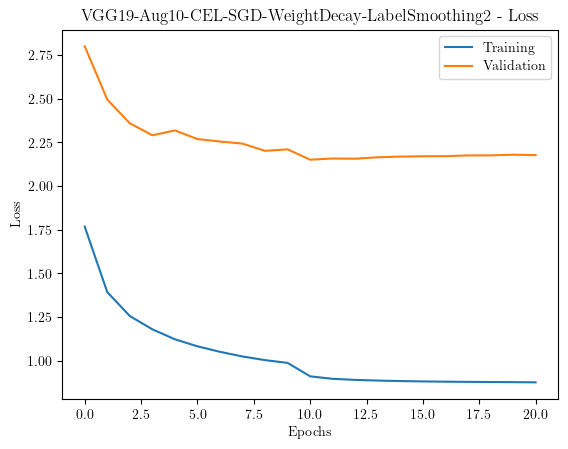

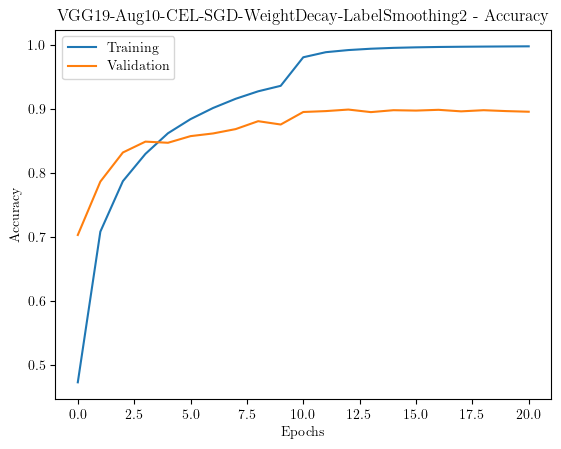

In [63]:
vgg19_aug10_cel_sgd_wd_ls2.fit(50)
vgg19_aug10_cel_sgd_wd_ls2.plot()

In [64]:
experiment_name = "VGG19-Aug10-CEL-SGD-WeightDecay2-LabelSmoothing2"
vgg19_aug10_cel_sgd_wd2_ls2_model = VGG19(10).to(device)
vgg19_aug10_cel_sgd_wd2_ls2_model.apply(init_weights)

del train_loader
train_loader = DataLoader(train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = SGD(
    vgg19_aug10_cel_sgd_wd2_ls2_model.parameters(),
    lr=0.01,
    weight_decay=0.001,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

vgg19_aug10_cel_sgd_wd2_ls2 = Trainer(
    experiment_name,
    vgg19_aug10_cel_sgd_wd2_ls2_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [65]:
vgg19_aug10_cel_sgd_wd2_ls2.fit(50)
vgg19_aug10_cel_sgd_wd2_ls2.plot()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01000  T_Loss: 1.7831   V_Loss: 2.9357   T_Acc: 0.46   V_Acc: 0.67
Epoch [2/50]  LR: 0.01000  T_Loss: 1.4170   V_Loss: 2.5724   T_Acc: 0.69   V_Acc: 0.77
Epoch [3/50]  LR: 0.01000  T_Loss: 1.2789   V_Loss: 2.3902   T_Acc: 0.77   V_Acc: 0.82
Epoch [4/50]  LR: 0.01000  T_Loss: 1.2027   V_Loss: 2.3314   T_Acc: 0.82   V_Acc: 0.84
Epoch [5/50]  LR: 0.01000  T_Loss: 1.1516   V_Loss: 2.2990   T_Acc: 0.85   V_Acc: 0.85
Epoch [6/50]  LR: 0.01000  T_Loss: 1.1132   V_Loss: 2.2243   T_Acc: 0.87   V_Acc: 0.87
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.01000  T_Loss: 1.0847   V_Loss: 2.2618   T_Acc: 0.88   V_Acc: 0.86
Epoch [8/50]  LR: 0.01000  T_Loss: 1.0612   V_Loss: 2.1792   T_Acc: 0.90   V_Acc: 0.88
EarlyStopping counter: 1 out of 10
Epoch [9/50]  LR: 0.01000  T_Loss: 1.0433   V_Loss: 2.2292   T_Acc: 0.91   V_Acc: 0.86
EarlyStopping counter: 2 out of 10
Epoch [10/50]  LR: 0.01000  T_Loss: 1.0277   V_Loss: 2.1900   T_Acc: 0.91   V_Acc: 0.87
Epoch [11/50]  LR: 0.001

KeyboardInterrupt: 

In [22]:
from utils.dataset import CF10FlyAugmentedDataset


experiment_name = "VGG19-FlyAug-CEL-SGD-WeightDecay-LabelSmoothing"
vgg19_flyaug_cel_sgd_wd_ls_model = VGG19(10).to(device)
vgg19_flyaug_cel_sgd_wd_ls_model.apply(init_weights)

torch.cuda.empty_cache()
del train_loader
train_fly_aug_ds = CF10FlyAugmentedDataset(train_set.imgs, train_set.labels)
train_loader = DataLoader(train_fly_aug_ds, batch_size=256, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = SGD(
    vgg19_flyaug_cel_sgd_wd_ls_model.parameters(),
    lr=0.01,
    weight_decay=0.001,
    momentum=0.9,
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

vgg19_flyaug_cel_sgd_wd_ls = Trainer(
    experiment_name,
    vgg19_flyaug_cel_sgd_wd_ls_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [23]:
vgg19_flyaug_cel_sgd_wd_ls.fit(50)
vgg19_flyaug_cel_sgd_wd_ls.plot()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00100  T_Loss: 3.0424   V_Loss: 4.6055   T_Acc: 0.10   V_Acc: 0.10
Epoch [2/50]  LR: 0.00100  T_Loss: 2.3027   V_Loss: 4.6053   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 1 out of 10
Epoch [3/50]  LR: 0.00100  T_Loss: 2.3028   V_Loss: 4.6054   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 2 out of 10
Epoch [4/50]  LR: 0.00100  T_Loss: 2.3028   V_Loss: 4.6053   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 3 out of 10
Epoch [5/50]  LR: 0.00100  T_Loss: 2.3028   V_Loss: 4.6053   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 4 out of 10
Epoch [6/50]  LR: 0.00100  T_Loss: 2.3028   V_Loss: 4.6053   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 5 out of 10
Epoch [7/50]  LR: 0.00100  T_Loss: 2.3027   V_Loss: 4.6053   T_Acc: 0.10   V_Acc: 0.10
Epoch [8/50]  LR: 0.00100  T_Loss: 2.3027   V_Loss: 4.6052   T_Acc: 0.10   V_Acc: 0.10
EarlyStopping counter: 1 out of 10
Epoch [9/50]  LR: 0.00100  T_Loss: 2.3028   V_Loss: 4.6056   T_Acc: 0.10   V_Acc: 0.10


KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.00010  T_Loss: 1.0507   V_Loss: 2.1404   T_Acc: 0.90   V_Acc: 0.89
EarlyStopping counter: 1 out of 10
Epoch [2/50]  LR: 0.00010  T_Loss: 1.0471   V_Loss: 2.1419   T_Acc: 0.90   V_Acc: 0.89
EarlyStopping counter: 2 out of 10
Epoch [3/50]  LR: 0.00010  T_Loss: 1.0472   V_Loss: 2.1431   T_Acc: 0.91   V_Acc: 0.89
Epoch [4/50]  LR: 0.00010  T_Loss: 1.0483   V_Loss: 2.1400   T_Acc: 0.90   V_Acc: 0.89
Epoch [5/50]  LR: 0.00010  T_Loss: 1.0473   V_Loss: 2.1393   T_Acc: 0.90   V_Acc: 0.89
Epoch [6/50]  LR: 0.00010  T_Loss: 1.0484   V_Loss: 2.1380   T_Acc: 0.90   V_Acc: 0.89
EarlyStopping counter: 1 out of 10
Epoch [7/50]  LR: 0.00010  T_Loss: 1.0445   V_Loss: 2.1389   T_Acc: 0.91   V_Acc: 0.89
EarlyStopping counter: 2 out of 10
Epoch [8/50]  LR: 0.00010  T_Loss: 1.0467   V_Loss: 2.1385   T_Acc: 0.91   V_Acc: 0.89
EarlyStopping counter: 3 out of 10
Epoch [9/50]  LR: 0.00010  T_Loss: 1.0441   V_Loss: 2.1404   T_Acc: 0.91   V_Acc: 0.89
EarlyStopping counter: 4 out of 10
Epoch [

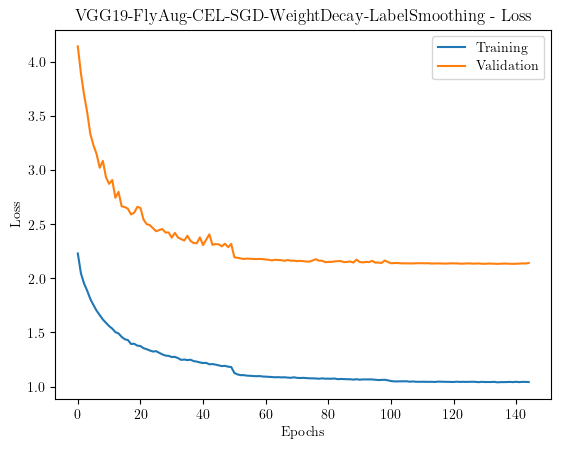

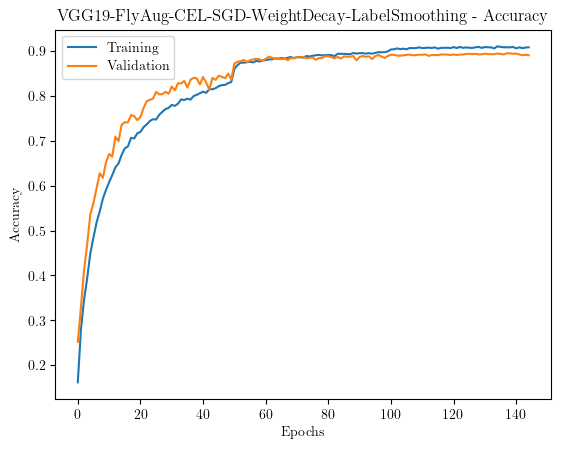

In [17]:
vgg19_flyaug_cel_sgd_wd_ls.fit(50)
vgg19_flyaug_cel_sgd_wd_ls.plot()

### ResNet-18
Augmented 10, CEL, SGD, CosineAnnLR

In [10]:
from torchvision.models import resnet18

experiment_name = "ResNet18-CEL-SGD"
# resnet18_cel_sgd_model = ResNet18(10).to(device)
# resnet18_cel_sgd_model.apply(init_kaiming)
resnet18_cel_sgd_model = resnet18(num_classes=10).to(device)

train_loader = DataLoader(
    train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = SGD(
    resnet18_cel_sgd_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

resnet18_cel_sgd = Trainer(
    experiment_name,
    resnet18_cel_sgd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
)

In [13]:
resnet18_cel_sgd.fit(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200]  LR: 0.00618  T_Loss: 0.5551   V_Loss: 1.8621   T_Acc: 0.98   V_Acc: 0.85
Epoch [2/200]  LR: 0.00476  T_Loss: 0.5347   V_Loss: 1.8207   T_Acc: 0.99   V_Acc: 0.86
EarlyStopping counter: 1 out of 10
Epoch [3/200]  LR: 0.00351  T_Loss: 0.5189   V_Loss: 1.8416   T_Acc: 0.99   V_Acc: 0.86
EarlyStopping counter: 2 out of 10
Epoch [4/200]  LR: 0.00245  T_Loss: 0.5094   V_Loss: 1.8287   T_Acc: 1.00   V_Acc: 0.86
EarlyStopping counter: 3 out of 10
Epoch [5/200]  LR: 0.00157  T_Loss: 0.5040   V_Loss: 1.8372   T_Acc: 1.00   V_Acc: 0.86
EarlyStopping counter: 4 out of 10
Epoch [6/200]  LR: 0.00089  T_Loss: 0.5025   V_Loss: 1.8255   T_Acc: 1.00   V_Acc: 0.86
Epoch [7/200]  LR: 0.00039  T_Loss: 0.5020   V_Loss: 1.8201   T_Acc: 1.00   V_Acc: 0.86
EarlyStopping counter: 1 out of 10
Epoch [8/200]  LR: 0.00010  T_Loss: 0.5018   V_Loss: 1.8232   T_Acc: 1.00   V_Acc: 0.86
EarlyStopping counter: 2 out of 10
Epoch [9/200]  LR: 0.00000  T_Loss: 0.5018   V_Loss: 1.8204   T_Acc: 1.00   V_Acc: 0.8

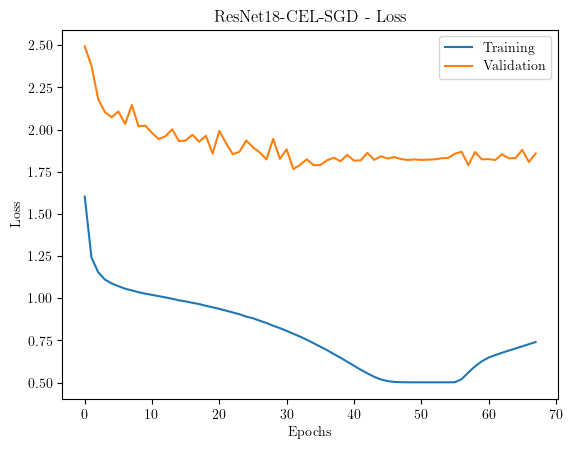

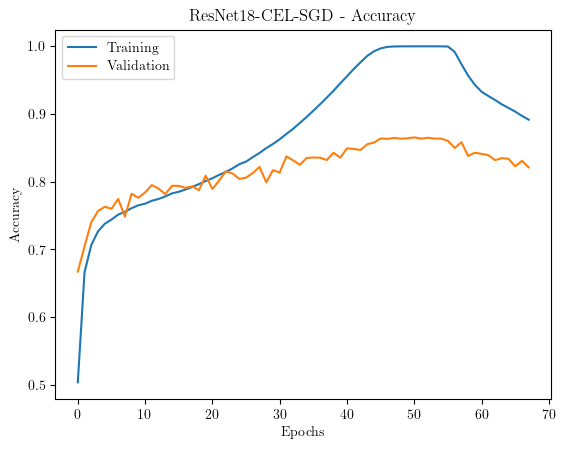

In [14]:
resnet18_cel_sgd.plot()

In [21]:
experiment_name = "ResNet18-CEL-SGD-Mixup"
# resnet18_cel_sgd_mixup_model = ResNet18(10).to(device)
# resnet18_cel_sgd_mixup_model.apply(init_kaiming)
resnet18_cel_sgd_mixup_model = resnet18(num_classes=10).to(device)

train_loader = DataLoader(
    train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = SGD(
    resnet18_cel_sgd_mixup_model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

resnet18_cel_sgd_mixup = Trainer(
    experiment_name,
    resnet18_cel_sgd_mixup_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
    mixup=True
)

In [22]:
resnet18_cel_sgd_mixup.fit(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200] M LR: 0.01000  T_Loss: 1.9262   V_Loss: 2.7074   T_Acc: 0.29   V_Acc: 0.63
Epoch [2/200] M LR: 0.01000  T_Loss: 1.7622   V_Loss: 2.5387   T_Acc: 0.35   V_Acc: 0.68
Epoch [3/200] M LR: 0.01000  T_Loss: 1.6890   V_Loss: 2.4117   T_Acc: 0.36   V_Acc: 0.71
Epoch [4/200] M LR: 0.01000  T_Loss: 1.6386   V_Loss: 2.2628   T_Acc: 0.39   V_Acc: 0.75
Epoch [5/200] M LR: 0.01000  T_Loss: 1.6001   V_Loss: 2.2085   T_Acc: 0.39   V_Acc: 0.76
EarlyStopping counter: 1 out of 10
Epoch [6/200] M LR: 0.01000  T_Loss: 1.5923   V_Loss: 2.2229   T_Acc: 0.39   V_Acc: 0.75
Epoch [7/200] M LR: 0.01000  T_Loss: 1.5641   V_Loss: 2.1995   T_Acc: 0.41   V_Acc: 0.77
Epoch [8/200] M LR: 0.01000  T_Loss: 1.5390   V_Loss: 2.0830   T_Acc: 0.42   V_Acc: 0.79
EarlyStopping counter: 1 out of 10
Epoch [9/200] M LR: 0.01000  T_Loss: 1.5198   V_Loss: 2.1657   T_Acc: 0.43   V_Acc: 0.77
Epoch [10/200] M LR: 0.01000  T_Loss: 1.5183   V_Loss: 2.0600   T_Acc: 0.43   V_Acc: 0.79
Epoch [11/200] M LR: 0.01000  T_Loss: 1

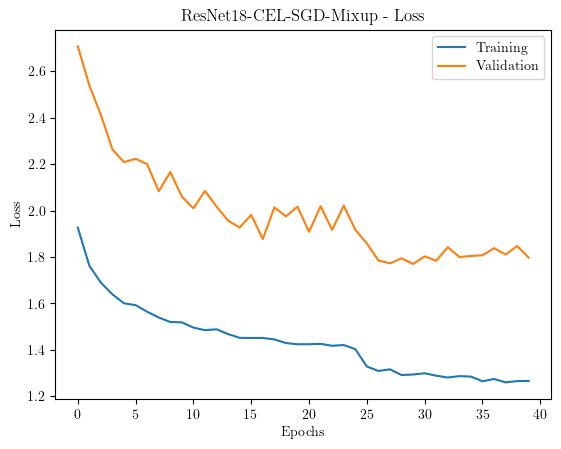

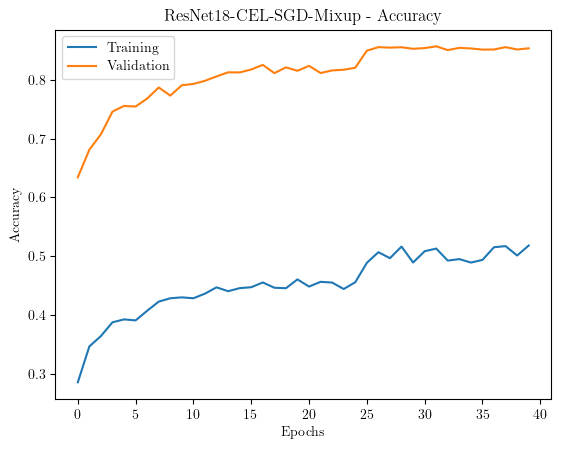

In [23]:
resnet18_cel_sgd_mixup.plot()

In [28]:
from utils.models import ResNet18Dropout

experiment_name = "ResNet18-CEL-SGD-Mixup-Dropout"
resnet18_cel_sgd_mixup_dropout_model = ResNet18Dropout(10).to(device)
resnet18_cel_sgd_mixup_dropout_model.apply(init_kaiming)

train_loader = DataLoader(
    train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = SGD(
    resnet18_cel_sgd_mixup_dropout_model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

resnet18_cel_sgd_mixup_dropout = Trainer(
    experiment_name,
    resnet18_cel_sgd_mixup_dropout_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
    mixup=True
)

In [29]:
resnet18_cel_sgd_mixup_dropout.fit(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200] M LR: 0.01000  T_Loss: 2.0253   V_Loss: 3.1420   T_Acc: 0.26   V_Acc: 0.57
Epoch [2/200] M LR: 0.01000  T_Loss: 1.8154   V_Loss: 2.6627   T_Acc: 0.33   V_Acc: 0.65
Epoch [3/200] M LR: 0.01000  T_Loss: 1.7413   V_Loss: 2.4328   T_Acc: 0.35   V_Acc: 0.70
Epoch [4/200] M LR: 0.01000  T_Loss: 1.6935   V_Loss: 2.3708   T_Acc: 0.37   V_Acc: 0.72
Epoch [5/200] M LR: 0.01000  T_Loss: 1.6439   V_Loss: 2.3185   T_Acc: 0.38   V_Acc: 0.72
Epoch [6/200] M LR: 0.01000  T_Loss: 1.6304   V_Loss: 2.2881   T_Acc: 0.39   V_Acc: 0.74
Epoch [7/200] M LR: 0.01000  T_Loss: 1.6034   V_Loss: 2.1614   T_Acc: 0.41   V_Acc: 0.76
Epoch [8/200] M LR: 0.01000  T_Loss: 1.5835   V_Loss: 2.1138   T_Acc: 0.41   V_Acc: 0.78
Epoch [9/200] M LR: 0.01000  T_Loss: 1.5554   V_Loss: 2.0909   T_Acc: 0.41   V_Acc: 0.79
Epoch [10/200] M LR: 0.01000  T_Loss: 1.5444   V_Loss: 2.0891   T_Acc: 0.41   V_Acc: 0.77
Epoch [11/200] M LR: 0.01000  T_Loss: 1.5267   V_Loss: 2.0263   T_Acc: 0.42   V_Acc: 0.80
Epoch [12/200] M LR

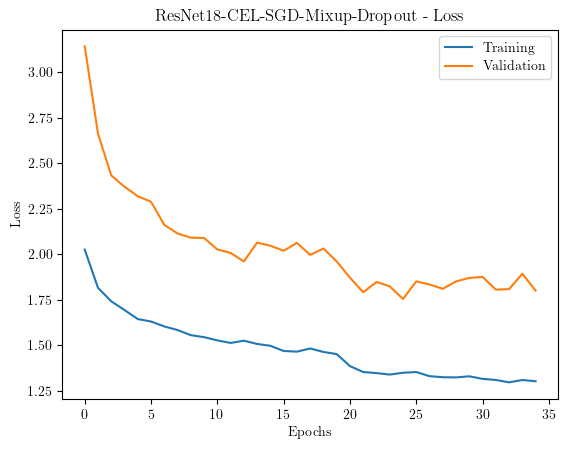

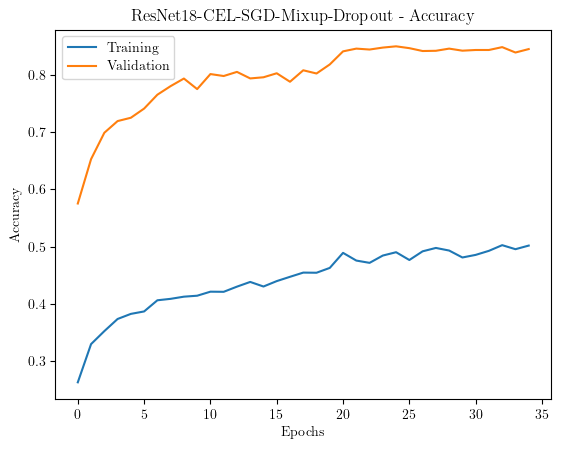

In [30]:
resnet18_cel_sgd_mixup_dropout.plot()

In [39]:
from utils.models import ResNet18DropoutNoise

experiment_name = "ResNet18-CEL-SGD-Mixup-Dropout"
resnet18_cel_sgd_mixup_dropout_noise_model = ResNet18DropoutNoise(10).to(device)
resnet18_cel_sgd_mixup_dropout_noise_model.apply(init_kaiming)

train_loader = DataLoader(
    train_aug_10_ds, batch_size=256, num_workers=4, shuffle=True
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = SGD(
    resnet18_cel_sgd_mixup_dropout_noise_model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9, nesterov=True
)
early_stop = EarlyStopping(
    patience=10, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

resnet18_cel_sgd_mixup_dropout_noise = Trainer(
    experiment_name,
    resnet18_cel_sgd_mixup_dropout_noise_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    lambda _: scheduler.step(),
    mixup=True
)

In [40]:
resnet18_cel_sgd_mixup_dropout_noise.fit(200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200] M LR: 0.01000  T_Loss: 2.0368   V_Loss: 3.0426   T_Acc: 0.26   V_Acc: 0.56
Epoch [2/200] M LR: 0.01000  T_Loss: 1.8350   V_Loss: 2.6408   T_Acc: 0.32   V_Acc: 0.65
Epoch [3/200] M LR: 0.01000  T_Loss: 1.7621   V_Loss: 2.4731   T_Acc: 0.35   V_Acc: 0.69
Epoch [4/200] M LR: 0.01000  T_Loss: 1.7174   V_Loss: 2.4259   T_Acc: 0.36   V_Acc: 0.71
Epoch [5/200] M LR: 0.01000  T_Loss: 1.6688   V_Loss: 2.2871   T_Acc: 0.37   V_Acc: 0.73
Epoch [6/200] M LR: 0.01000  T_Loss: 1.6460   V_Loss: 2.2070   T_Acc: 0.39   V_Acc: 0.76
Epoch [7/200] M LR: 0.01000  T_Loss: 1.6205   V_Loss: 2.1622   T_Acc: 0.40   V_Acc: 0.77
Epoch [8/200] M LR: 0.01000  T_Loss: 1.5952   V_Loss: 2.1144   T_Acc: 0.40   V_Acc: 0.77
Epoch [9/200] M LR: 0.01000  T_Loss: 1.5841   V_Loss: 2.0732   T_Acc: 0.40   V_Acc: 0.78
EarlyStopping counter: 1 out of 10
Epoch [10/200] M LR: 0.01000  T_Loss: 1.5684   V_Loss: 2.0919   T_Acc: 0.42   V_Acc: 0.79
EarlyStopping counter: 2 out of 10
Epoch [11/200] M LR: 0.01000  T_Loss: 1

KeyboardInterrupt: 

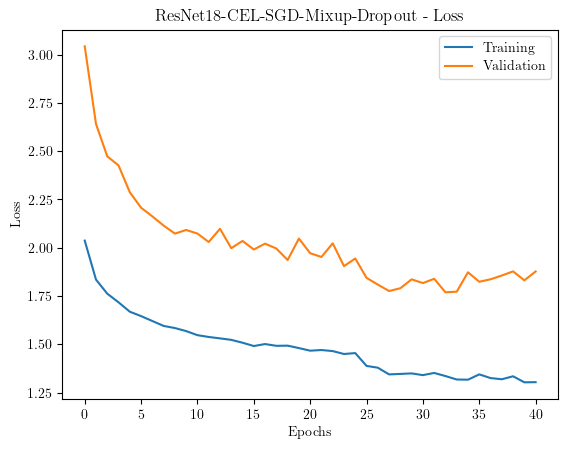

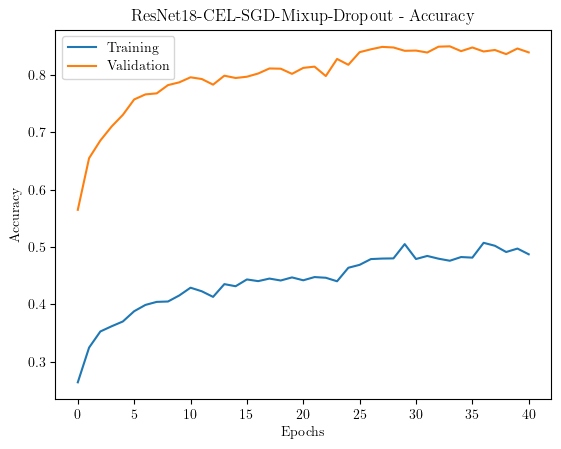

In [41]:
resnet18_cel_sgd_mixup_dropout_noise.plot()

### ResNet-50
Augmented 3, CEL, SGD, StepLR

In [30]:
torch.cuda.empty_cache()

experiment_name = "ResNet50-CEL-SGD"
resnet50_cel_sgd_model = ResNet50(10).to(device)
resnet50_cel_sgd_model.apply(init_kaiming)

train_loader = DataLoader(
    train_aug_3_ds, batch_size=256, num_workers=4, shuffle=True
)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(
    resnet50_cel_sgd_model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.2
)
early_stop = EarlyStopping(
    patience=5, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
# def scheduler_callback(metrics):
#     StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
def scheduler_callback(metrics):
    scheduler.step(metrics)

resnet50_cel_sgd = Trainer(
    experiment_name,
    resnet50_cel_sgd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    scheduler_callback
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01  T_Loss: 2.1172   V_Loss: 4.3816   T_Acc: 0.30   V_Acc: 0.38
Epoch [2/50]  LR: 0.01  T_Loss: 1.5803   V_Loss: 4.1554   T_Acc: 0.42   V_Acc: 0.29
Epoch [3/50]  LR: 0.01  T_Loss: 1.3982   V_Loss: 3.1704   T_Acc: 0.49   V_Acc: 0.43
Epoch [4/50]  LR: 0.01  T_Loss: 1.2835   V_Loss: 2.9938   T_Acc: 0.54   V_Acc: 0.47
Epoch [5/50]  LR: 0.01  T_Loss: 1.1880   V_Loss: 2.8054   T_Acc: 0.57   V_Acc: 0.51
EarlyStopping counter: 1 out of 5
Epoch [6/50]  LR: 0.01  T_Loss: 1.1027   V_Loss: 2.8469   T_Acc: 0.60   V_Acc: 0.50
Epoch [7/50]  LR: 0.01  T_Loss: 1.0211   V_Loss: 2.7351   T_Acc: 0.64   V_Acc: 0.53
EarlyStopping counter: 1 out of 5
Epoch [8/50]  LR: 0.01  T_Loss: 0.9407   V_Loss: 3.3673   T_Acc: 0.66   V_Acc: 0.51
EarlyStopping counter: 2 out of 5
Epoch [9/50]  LR: 0.01  T_Loss: 0.8672   V_Loss: 3.2557   T_Acc: 0.69   V_Acc: 0.49
EarlyStopping counter: 3 out of 5
Epoch [10/50]  LR: 0.01  T_Loss: 0.7943   V_Loss: 2.8245   T_Acc: 0.72   V_Acc: 0.56
EarlyStopping counter: 

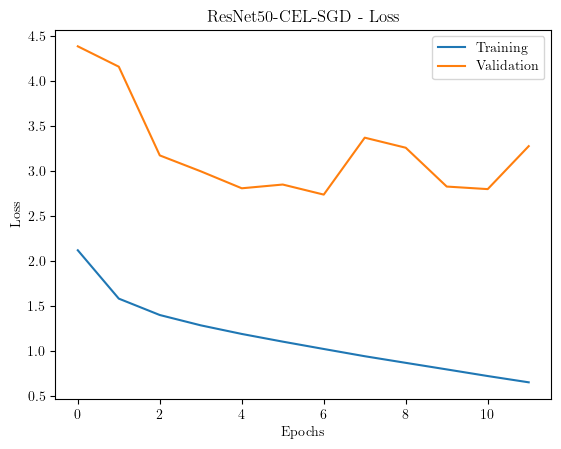

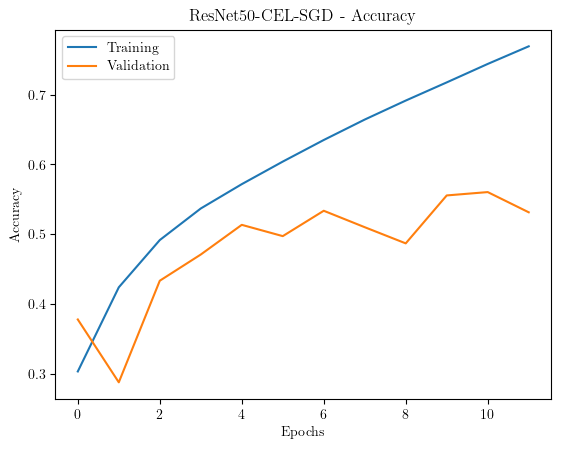

In [31]:
resnet50_cel_sgd.fit(50)
resnet50_cel_sgd.plot()

In [23]:
from utils.models import ResNet50Mod

experiment_name = "ResNet50Mod-CEL-SGD"
resnet50_mod_cel_sgd_model = ResNet50Mod(10).to(device)
resnet50_mod_cel_sgd_model.apply(init_kaiming)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(
    resnet50_mod_cel_sgd_model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9
)
early_stop = EarlyStopping(
    patience=5, path=f"checkpoints/{experiment_name}-checkpoint.pt"
)
def scheduler (metrics):
    StepLR(optimizer, step_size=3, gamma=0.1)

resnet50_mod_cel_sgd = Trainer(
    experiment_name,
    resnet50_mod_cel_sgd_model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stop,
    scheduler,
)

In [24]:
resnet50_mod_cel_sgd.fit(50)
resnet50_mod_cel_sgd.plot()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  LR: 0.01  T_Loss: 1.6397   V_Loss: 2.6887   T_Acc: 0.43   V_Acc: 0.52
EarlyStopping counter: 1 out of 5
Epoch [2/50]  LR: 0.01  T_Loss: 1.3054   V_Loss: 2.7641   T_Acc: 0.53   V_Acc: 0.52


Exception ignored in: <function _releaseLock at 0x7915b6988a40>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch [3/50]  LR: 0.01  T_Loss: 0.9974   V_Loss: 1.8430   T_Acc: 0.64   V_Acc: 0.67


KeyboardInterrupt: 

In [26]:
test_loader = DataLoader(test_ds, batch_size=2500, num_workers=2, shuffle=False, pin_memory=True)

In [27]:
checkpoint = torch.load("checkpoints/ResNet50Mod-CEL-SGD-checkpoint.pt")
resnet50_mod_cel_sgd_model.load_state_dict(checkpoint)
resnet50_mod_cel_sgd_model.eval()
test_model(resnet50_mod_cel_sgd_model, test_loader)

/tmp/ipykernel_151298/718503687.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/ResNet50Mod-CEL-SGD-checkpoint.pt")


Accuracy: 67.64 %


In [62]:

checkpoint = torch.load('checkpoints/VGG19-CEL-SGD-checkpoint.pt')
vgg19_plain_cel_sgd_model.load_state_dict(checkpoint)
test_model(vgg19_cel_adam_model, test_loader)

/tmp/ipykernel_52140/3786398137.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/VGG19-CEL-SGD-checkpoint.pt')


Accuracy: 10.00 %


## Sources

https://arxiv.org/pdf/1409.1556
https://www.geeksforgeeks.org/vgg-net-architecture-explained/
https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch
https://www.kaggle.com/code/mehmetlaudatekman/cifar-10-vgg19-transfer-learning
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
https://saturncloud.io/blog/how-to-normalize-image-dataset-using-pytorch/
https://www.kaggle.com/code/ayushnitb/cifar10-custom-resnet-cnn-pytorch-97-acc

https://arxiv.org/pdf/1512.03385
https://arxiv.org/abs/1502.01852